In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.spatial import cKDTree
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split


## preprocessing steps and recomputation of features

In [2]:
# load data
burn_areas = gpd.read_file('fire-ignitions/campania/campania_burn_areas_2007_2021.shp')
static = gpd.read_file('static-predictors/static_predictors.shp')
# load event_df
event_df = pd.read_csv('event_data_2007_2020_final1.csv')
event_df = event_df.dropna()
event_df['geometry'] = event_df['geometry'].apply(loads)
df_monthly = pd.read_csv('df_summary_monthly.csv')
df_overall = pd.read_csv('df_summary_overall.csv')

In [3]:
event_df = event_df.sort_values(["id", "start_time"]).copy()

def fix_no_prior_fire(group):
    """
    For each grid (group), the first row is set to no_prior_fire=1.
    If we have already seen a fire in earlier rows, then no_prior_fire=0 for subsequent rows.
    """
    has_seen_fire = False
    for i in group.index:
        if i == group.index[0]:
            # first row in this grid
            group.loc[i, "no_prior_fire"] = 1
        else:
            # subsequent rows
            group.loc[i, "no_prior_fire"] = 0 if has_seen_fire else 1

        # If this row has a fire, update flag
        if group.loc[i, "fire_occurred_x"] == 1:
            has_seen_fire = True
    return group

# Apply the logic per grid (grouped by 'id')
event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)

# (Optional) re-sort or reset index if you wish
event_df = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

C:\Users\hclt0\AppData\Local\Temp\ipykernel_10896\4029580595.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


In [4]:
import numpy as np
import pandas as pd


# If you haven’t already, define no_prior_fire per id:
no_fire_map = (
    event_df.groupby("id")["fire_occurred_x"]
            .max()
            .apply(lambda x: 0 if x == 1 else 1)
)
event_df["no_prior_fire"] = event_df["id"].map(no_fire_map)

# ────────────────────────────────────────────────────────────────
# 1) Define a version of compute_days_since_fire that uses ints
# ────────────────────────────────────────────────────────────────
def compute_days_since_fire_int(group):
    group = group.sort_values("start_time").copy()
    last_fire_stop = None
    days_list = []

    for _, row in group.iterrows():
        if last_fire_stop is None:
            # first interval: if no_prior_fire=1 we say “1 day”, else 0
            days = 1 if row["no_prior_fire"] == 1 else 0
        else:
            # subtract integer days
            days = row["stop_time"] - last_fire_stop

        days_list.append(days)

        # only update the “last fire” counter on actual fire events
        if row["fire_occurred_x"] == 1:
            last_fire_stop = row["stop_time"]

    group["days_since_last_fire"] = days_list
    return group

# ────────────────────────────────────────────────────────────────
# 2) Apply it per grid
# ────────────────────────────────────────────────────────────────
df = (
    event_df
      .groupby("id", group_keys=False)
      .apply(compute_days_since_fire_int)
      .reset_index(drop=True)
)

# ────────────────────────────────────────────────────────────────
# 3) Post-processing: force any 0 → 1 if you prefer no zero-days
# ────────────────────────────────────────────────────────────────
df["days_since_last_fire"] = df["days_since_last_fire"].replace(0, 1)

# If you need to refresh no_prior_fire (it shouldn’t change), you can redo:
no_fire_map = (
    df.groupby("id")["fire_occurred_x"]
      .max()
      .apply(lambda x: 0 if x == 1 else 1)
)
df["no_prior_fire"] = df["id"].map(no_fire_map)

event_df = df  # overwrite your original

# ────────────────────────────────────────────────────────────────
# 4) Inspect
# ────────────────────────────────────────────────────────────────
event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)
event_df = event_df.dropna()
print(event_df[[
    "id", "stop_time", "fire_occurred_x",
    "days_since_last_fire", "no_prior_fire"
]].head(30))


C:\Users\hclt0\AppData\Local\Temp\ipykernel_10896\1670196970.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df


    id  stop_time  fire_occurred_x  days_since_last_fire  no_prior_fire
0    7       1730                0                     1              1
1    7       2655                0                     1              1
2    7       5075                0                     1              1
3    8       1665                1                     1              1
4    8       1753                0                    88              0
5    8       2050                0                   385              0
6    8       3834                1                  2169              0
7    8       5075                0                  1241              0
8    9        842                0                     1              1
9    9       2337                0                     1              1
10   9       5075                0                     1              1
11  36       3285                0                     1              1
12  36       3966                0                     1        

C:\Users\hclt0\AppData\Local\Temp\ipykernel_10896\1670196970.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


In [5]:
numeric_cols = [
    "temperature", "wind_speed", "drought20", "forest", "road", "grass", "shrub", "agri",
    "days_since_last_fire", "powerline", "humidity", "mean_eleva", "max_elevat"
]

# Strip quotes and convert to numeric
for col in numeric_cols:
    if event_df[col].dtype == object:
        event_df[col] = pd.to_numeric(event_df[col].astype(str).str.replace('"', ''), errors='coerce')

In [6]:
import pandas as pd

# 1) Columns to exclude
exclude = {
    "sin_month", "cos_month","no_prior_fire", "stop_time", "id", "start_time"
}

numeric_cols = event_df.select_dtypes(include="number").columns
key_cols = [c for c in numeric_cols if c not in exclude]

# 3) Compute mean and standard deviation
means = event_df[key_cols].mean().round(5)
stds  = event_df[key_cols].std(ddof=1).round(5)

# 4) Build summary DataFrame
summary = pd.DataFrame({
    "Covariate":   key_cols,
    "Mean":        means.values,
    "Std. Dev.":   stds.values
})

# 5) Print it
print(summary.to_string(index=False))


           Covariate        Mean   Std. Dev.
     fire_occurred_x     0.54872     0.49764
     fire_occurred_y     0.54879     0.49763
                road 19454.84532 11715.87576
           powerline  6504.30542  7692.64472
          night_ligh    55.19168    81.54053
          mean_eleva   411.67246   257.76681
          max_elevat   833.60305   370.74592
             slope30     0.06235     0.07938
               north     0.33191     0.14511
                east     0.10863     0.06958
               south     0.42686     0.14695
                west     0.13260     0.06552
                 wui     0.04578     0.05725
              agriNA     0.08987     0.08596
               grass     0.03222     0.05950
              forest     0.31764     0.22775
               shrub     0.07136     0.08304
               other     0.02845     0.06011
                agri     0.27584     0.18851
days_since_last_fire   323.26680   582.74826
          wind_speed     9.59902     2.88050
       pre

## find a good temporal cutoff that don't collide with data structure

In [7]:
import numpy as np

# 1) Collect all integer‐rounded boundaries in your window
lower, upper = 4000, 4100
candidates = np.arange(lower, upper + 1)

# Round your actual start/stop times to nearest integer
used = set(np.round(event_df["start_time"]).astype(int)) \
     | set(np.round(event_df["stop_time"]).astype(int))

# 2) Find which candidates are “free”
free = [t for t in candidates if t not in used]

if not free:
    raise ValueError(f"No free threshold found in [{lower},{upper}]")

# 3) Pick one—e.g. the middle of the free zone
T0 = free[len(free)//2]
print(f"Using temporal cutoff T0 = {T0}, which is free of existing boundaries.")

# 4) Then proceed with your split at T0


Using temporal cutoff T0 = 4053, which is free of existing boundaries.


In [7]:

def compute_seasonality_cos_sin(t_days):
    cos_month = np.cos(2 * np.pi * (t_days % 365) / 365)
    sin_month = np.sin(2 * np.pi * (t_days % 365) / 365)
    return cos_month, sin_month


def day_to_month(day):
    # Approximate conversion: assume 30-day months
    return min(12, int(day // 30) + 1)

def get_monthly_values(df_monthly, grid_id, month, stat='median'):
    """
    Retrieve monthly values (e.g., temperature, wind_speed, drought20)
    for the specified grid and month.
    Assumes df_monthly has columns like 'temperature_median', etc.
    """
    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    suffix = f"_{stat}"
    return {
        "temperature": row[f"temperature{suffix}"].values[0],
        "wind_speed": row[f"wind_speed{suffix}"].values[0],
        "drought20": row[f"drought20{stat}"].values[0] if f"drought20{stat}" in row.columns else row[f"drought20{suffix}"].values[0],
        "humidity": row[f"humidity{suffix}"].values[0],
    }

def build_baseline_row(event_df, grid_id):
    """
    Build a baseline row for the given grid (using the median) and ensure that required
    fixed covariates are present by pulling the first non-null value if needed.
    """
    subset = event_df[event_df["id"] == grid_id]
    if subset.empty:
        raise ValueError(f"No data for grid_id={grid_id}")
    baseline = subset.median(numeric_only=True).to_dict()
    required_features = [
        "powerline", "grass", "shrub", "agri", "forest", "road",
        "slope30", "mean_eleva", "no_prior_fire", "centroid_x", "centroid_y"
    ]
    for var in required_features:
        if var not in baseline or pd.isna(baseline[var]):
            non_null_values = subset[var].dropna()
            baseline[var] = non_null_values.iloc[0] if not non_null_values.empty else 0.0
    return baseline

def compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius):
    """
    Compute neighbor-based features (fire risk, forest, road, powerline, ERI)
    using a cKDTree based on the row’s centroid.
    """
    point = np.array([row["centroid_x"], row["centroid_y"]])
    neighbors = tree_train.query_ball_point(point, neighbor_radius)
    if not neighbors:
        for col in ["neighbor_fire_risk", "neighbor_forest", "neighbor_road", 
                    "neighbor_powerline", "neighbor_ERI"]:
            row[col] = df_train[col].median()
        return row
    neighs = df_train.iloc[neighbors]
    weights = 1 / (np.linalg.norm(coords_train[neighbors] - point, axis=1) + 1e-6)
    row.update({
        "neighbor_fire_risk": neighs["fire_occurred_x"].sum() / (neighs["duration"].sum() + 1e-9),
        "neighbor_forest": np.average(neighs["forest"], weights=weights),
        "neighbor_road": np.average(neighs["road"], weights=weights),
        "neighbor_powerline": np.average(neighs["powerline"], weights=weights),
        "neighbor_ERI": np.average(neighs["elevation_ruggedness_index"], weights=weights),
    })
    return row

## re - sort our data frame with the cutoff and fill the new splits with median values for that given month for each individual cell

In [8]:
import pandas as pd

T0 = 4053

# 1) Sort by id & start_time so we always split in order
df = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

new_rows = []
for _, r in df.iterrows():
    start, stop, event, gid = r["start_time"], r["stop_time"], r["fire_occurred_x"], r["id"]
    
    # if it crosses the cutoff
    if start < T0 < stop:
        # pre-cut piece (censored at T0)
        pre = r.to_dict()
        pre["stop_time"]   = T0
        pre["duration"]    = T0 - start
        pre["fire_occurred_x"]  = 0
        new_rows.append(pre)
        
        # post-cut piece (starts at T0, keeps original event flag)
        post = r.to_dict()
        post["start_time"] = T0
        post["duration"]   = stop - T0
        # post["fire_occur"] remains the original 0/1
        new_rows.append(post)
    else:
        # no split needed
        new_rows.append(r.to_dict())

df_split = pd.DataFrame(new_rows)
mask_post = df_split["stop_time"] == T0

def refresh_covariates(row):
    vals = get_monthly_values(df_monthly, row["id"], day_to_month(T0 % 365), stat="median")
    row["temperature"] = vals["temperature"]
    row["drought20"]  = vals["drought20"]
    row["wind_speed"] = vals["wind_speed"]
    row["humidity"]   = vals["humidity"]
    cos_m, sin_m = compute_seasonality_cos_sin(T0)
    row["cos_month"] = cos_m
    row["sin_month"] = sin_m
    return row

df_split.loc[mask_post] = df_split.loc[mask_post].apply(refresh_covariates, axis=1)

# Only pre‐cut, non‐fire rows with at least one prior fire
mask_pre = (
    (df_split["stop_time"] == T0)
    & (df_split["fire_occurred_x"] == 0)
    & (df_split["no_prior_fire"] == 0)
)

for idx in df_split[mask_pre].index:
    row = df_split.loc[idx]
    gid = row["id"]
    dur = row["duration"]

    # find the post‐cut piece: start_time == T0 for the same grid
    nxt = df_split[
        (df_split["id"] == gid)
        & (df_split["start_time"] == T0)
    ]
    if nxt.empty:
        continue

    next_dsf = nxt.iloc[0]["days_since_last_fire"]
    # subtract this truncated interval’s duration
    df_split.at[idx, "days_since_last_fire"] = next_dsf - dur


In [8]:
df_one_day = df_split[df_split["fire_occurred_x"] == 1]

# Count occurrences of fire_occurred_x in those rows
print(df_one_day["fire_occurred_x"].value_counts())

fire_occurred_x
1    8025
Name: count, dtype: int64


## fix the seasonality when we scale cos and sin month


In [9]:

def compute_seasonality_cos_sin(t_days):
    """
    Compute monthly seasonality as cosine and sine, then min–max scale both into [0,1].
    
    Parameters
    ----------
    t_days : float or array-like
        Number of days since some origin; will be reduced mod 365.
    
    Returns
    -------
    cos_month_scaled : float or array-like
    sin_month_scaled : float or array-like
    """
    # Compute raw angle on [0, 2π)
    angle = 2 * np.pi * (np.asarray(t_days) % 365) / 365.0
    
    # Raw cos and sin in [-1,1]
    cos_raw = np.cos(angle)
    sin_raw = np.sin(angle)
    
    # Min–max scale from [-1,1] to [0,1]
    cos_scaled = (cos_raw + 1) / 2.0
    sin_scaled = (sin_raw + 1) / 2.0
    
    return cos_scaled, sin_scaled

In [13]:
event_df = df_split

Train C-index: 0.8187
Test C-index: 0.8400


model,lifelines.CoxPHFitter
duration col,'duration'
event col,'fire_occurred_x'
cluster col,'id'
penalizer,0.01
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,12110
number of events observed,6671
partial log-likelihood,-54226.20


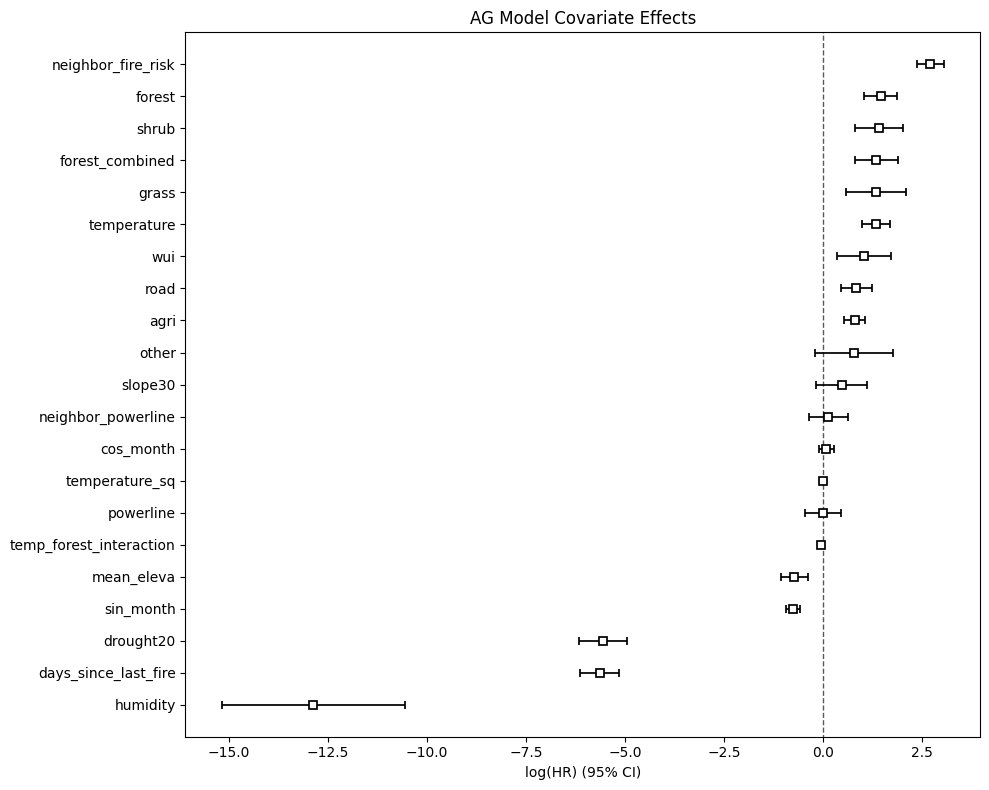

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from lifelines import CoxPHFitter
from scipy.spatial import cKDTree
import random

np.random.seed(42)
random.seed(42)
# Temporal cutoff: ~12 years
TEMPORAL_CUTOFF = 4053
NEIGHBOR_RADIUS = 5000

# Temporal split
df_train = df_split[df_split["start_time"] < TEMPORAL_CUTOFF].copy()
df_test = df_split[df_split["start_time"] >= TEMPORAL_CUTOFF].copy()

# Basic preprocessing
for df in [df_train, df_test]:
    df["centroid_x"] = df["geometry"].apply(lambda g: g.centroid.x)
    df["centroid_y"] = df["geometry"].apply(lambda g: g.centroid.y)
    df["duration"] = df["stop_time"] - df["start_time"]
    df["ruggedness"] = df["max_elevat"] - df["mean_eleva"]
    df["elevation_ruggedness_index"] = df["ruggedness"] * df["mean_eleva"]
    df["log_days_since_last_fire"] = np.log1p(df["days_since_last_fire"])

coords_train = df_train[["centroid_x", "centroid_y"]].values
tree_train = cKDTree(coords_train)

neighbor_features = [
    "neighbor_fire_risk", "neighbor_forest", "neighbor_road",
    "neighbor_powerline"
]

# Initialize neighbor features
for df in [df_train, df_test]:
    for f in neighbor_features:
        df[f] = np.nan


lag_days = 0  # or adjust to your preference
coords_train = df_train[["centroid_x", "centroid_y"]].values
coords_test  = df_test[["centroid_x",  "centroid_y"]].values
tree_train   = cKDTree(coords_train)

# TRAIN SET — uses historical neighbors only (with lag)
for i, pt in enumerate(coords_train):
    my_start = df_train.iloc[i]["start_time"]
    all_nb = tree_train.query_ball_point(pt, NEIGHBOR_RADIUS)
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_train.iloc[past_nb]
    dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_train.loc[df_train.index[i], "neighbor_fire_risk"]  = sub["fire_occurred_x"].sum() / sub["duration"].sum()
    df_train.loc[df_train.index[i], "neighbor_forest"]     = np.average(sub["forest"], weights=w)
    df_train.loc[df_train.index[i], "neighbor_road"]       = np.average(sub["road"], weights=w)
    df_train.loc[df_train.index[i], "neighbor_powerline"]  = np.average(sub["powerline"], weights=w)

# TEST SET — use only TRAIN history
for i, pt in enumerate(coords_test):
    my_start = df_test.iloc[i]["start_time"]
    all_nb = tree_train.query_ball_point(pt, NEIGHBOR_RADIUS)
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_train.iloc[past_nb]
    dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_test.loc[df_test.index[i], "neighbor_fire_risk"]  = sub["fire_occurred_x"].sum() / sub["duration"].sum()
    df_test.loc[df_test.index[i], "neighbor_forest"]     = np.average(sub["forest"], weights=w)
    df_test.loc[df_test.index[i], "neighbor_road"]       = np.average(sub["road"], weights=w)
    df_test.loc[df_test.index[i], "neighbor_powerline"]  = np.average(sub["powerline"], weights=w)

# Fill remaining NaNs
neighbor_features = ["neighbor_forest", "neighbor_road", "neighbor_powerline"]
for df in [df_train, df_test]:
    df[neighbor_features] = df[neighbor_features].fillna(df_train[neighbor_features].median())
    df["neighbor_fire_risk"] = df["neighbor_fire_risk"].fillna(0.0)


# Derived Features
for df in [df_train, df_test]:
    df["forest_combined"] = (df["forest"] + df["neighbor_forest"]) / 2
    df["temperature_sq"] = df["temperature"] ** 2
    df["wind_speed_sq"] = df["wind_speed"] ** 2
    df["temp_forest_interaction"] = df["temperature"] * df["forest_combined"]
    df["dsf_x_no_prior"] = df["days_since_last_fire"] * df["no_prior_fire"]

final_features = [
    "fire_occurred_x", "id", "temperature", "drought20",
    "forest_combined", "grass", "shrub", "forest",
    "neighbor_fire_risk", "neighbor_powerline","road", "powerline",
    "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction",
    "days_since_last_fire", "mean_eleva", "agri", "humidity", "slope30","other",
    "wui"
]

cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", 
    "forest", "other", "powerline", "wui", "cos_month", "sin_month"
]

scaler = MinMaxScaler()
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

df_train_final = df_train[final_features + ['duration']].copy()
df_test_final  = df_test [final_features + ['duration']].copy()
# Cox Model
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train_final, duration_col="duration", event_col="fire_occurred_x" ,cluster_col="id")

# Evaluate
train_c_index = cph.score(df_train_final, scoring_method="concordance_index")
test_c_index = cph.score(df_test_final , scoring_method="concordance_index")

ensemble_models = [{
    "model": cph,
    "scaler": scaler,
    "df_train_raw": df_train,
    "coords_train": coords_train,
    "tree_train": tree_train
}]

print(f"Train C-index: {train_c_index:.4f}")
print(f"Test C-index: {test_c_index:.4f}")
cph.print_summary()

# Plot covariate effects
plt.figure(figsize=(10,8))
cph.plot()
plt.title("AG Model Covariate Effects")
plt.tight_layout()
plt.show()

Integrated Brier Score: 0.1322 ± 0.0052


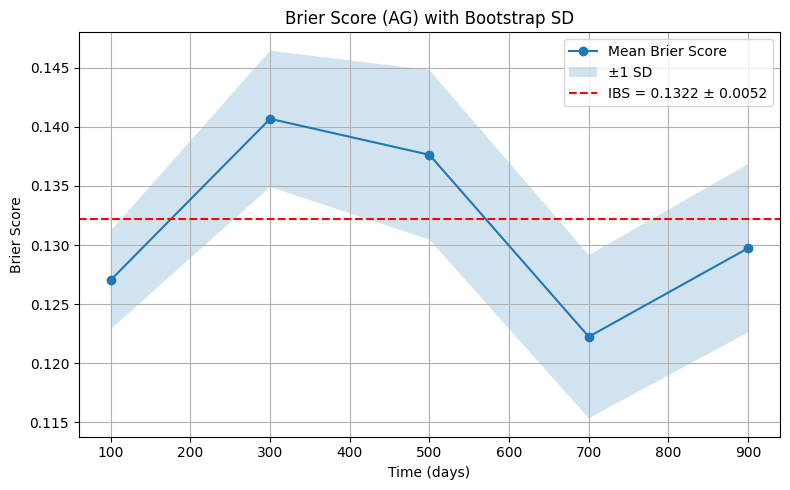

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score
from sksurv.util import Surv

# 1) Structured survival arrays
y_train_struct = Surv.from_arrays(
    event=df_train["fire_occurred_x"].astype(bool),
    time =df_train["duration"]
)
y_test_struct  = Surv.from_arrays(
    event=df_test["fire_occurred_x"].astype(bool),
    time =df_test["duration"]
)

# 2) Eval times
eval_times = np.arange(100, 1000, 200)

# 3) Precompute the full‐test survival‐matrix
pred_surv = cph.predict_survival_function(df_test[final_features], times=eval_times)
sf_full   = pred_surv.T.values     # shape (n_test, n_times)
n_test    = sf_full.shape[0]
n_times   = sf_full.shape[1]

# 4) Bootstrap Brier curves
n_bootstraps = 200
all_bs       = np.zeros((n_bootstraps, n_times))
indices      = np.arange(n_test)

for b in range(n_bootstraps):
    boot_idx      = np.random.choice(indices, size=n_test, replace=True)
    y_test_b      = y_test_struct[boot_idx]
    sf_b          = sf_full[boot_idx, :]
    _, bs_curve   = brier_score(y_train_struct, y_test_b, sf_b, eval_times)
    all_bs[b, :]  = bs_curve

# 5) Aggregate
mean_bs = all_bs.mean(axis=0)
std_bs  = all_bs.std(axis=0, ddof=1)

# compute IBS per bootstrap, then mean±std
ibs_boot = np.trapezoid(all_bs, eval_times, axis=1) / (eval_times[-1] - eval_times[0])
ibs_mean = ibs_boot.mean()
ibs_std  = ibs_boot.std(ddof=1)

print(f"Integrated Brier Score: {ibs_mean:.4f} ± {ibs_std:.4f}")

# 6) Plot
plt.figure(figsize=(8,5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 SD")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"IBS = {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (AG) with Bootstrap SD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


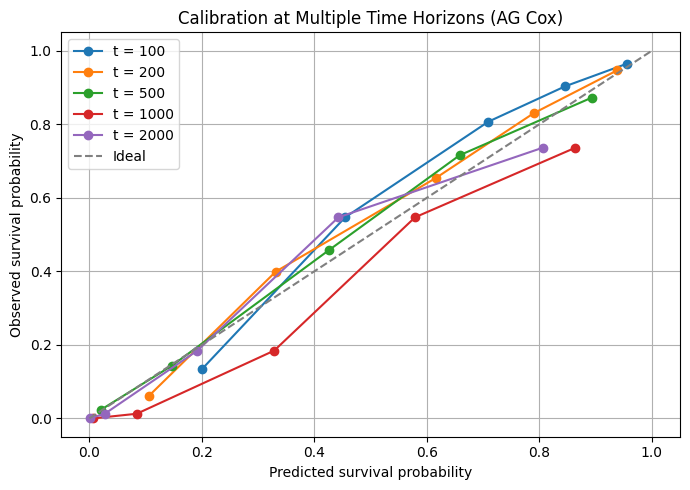

In [23]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

# 1. Choose time horizons
time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5

calibration_data = []

for t in time_horizons:
    # 2. Predict survival probabilities at time t
    surv_df = cph.predict_survival_function(df_test[final_features], times=[t])
    
    # lifelines returns DataFrame with time as index and rows = individuals
    pred_surv = surv_df.T[t].values  # shape (n_samples,)
    
    # 3. Bin individuals into quantiles based on predicted survival
    df_test["pred_surv_prob"] = pred_surv
    df_test["risk_group"] = pd.qcut(pred_surv, q=n_bins, labels=False)

    group_pred, group_obs = [], []
    kmf = KaplanMeierFitter()

    for group in range(n_bins):
        sub = df_test[df_test["risk_group"] == group]
        if len(sub) < 1:
            continue
        group_pred.append(sub["pred_surv_prob"].mean())
        kmf.fit(durations=sub["duration"], event_observed=sub["fire_occurred_x"])
        group_obs.append(kmf.predict(t))

    for gp, go in zip(group_pred, group_obs):
        calibration_data.append({"time": t, "pred": gp, "obs": go})

# 4. Plot
df_cal = pd.DataFrame(calibration_data)

plt.figure(figsize=(7, 5))
for t in df_cal["time"].unique():
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Multiple Time Horizons (AG Cox)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


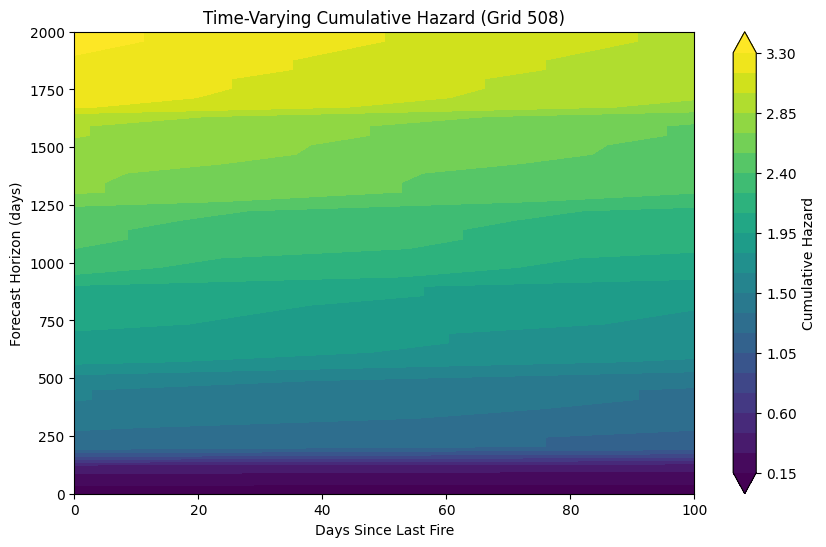

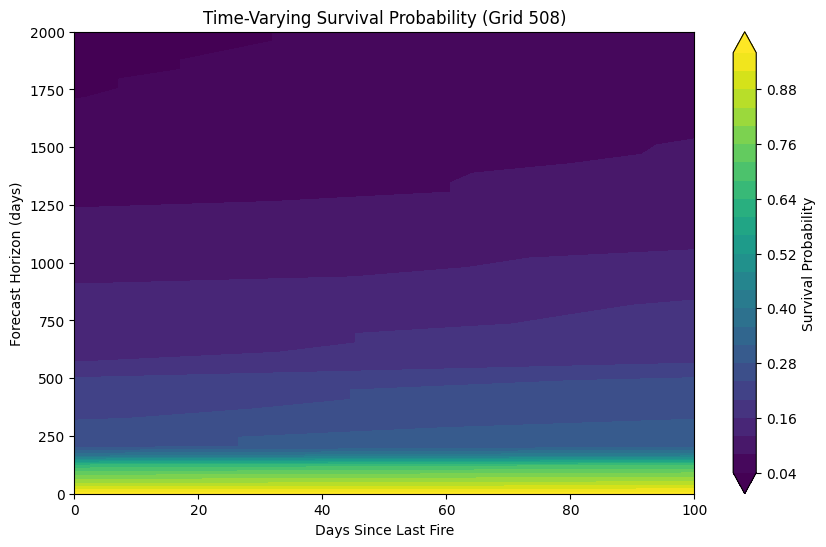

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=5000,
    sigma=0,
    delta_t=50
):
    days_since_fire_range = np.arange(0, 101, 5)
    forecast_range       = np.linspace(0, 2000, 50)

    # 1) Extract raw baseline cumulative hazard
    raw_baseline_df = ensemble_models[0]['model'] \
        .baseline_cumulative_hazard_ \
        .reset_index()
    raw_baseline_df.columns = ["time", "H0"]

    # Prepare output arrays
    piecewise_hazard  = np.zeros((len(forecast_range), len(days_since_fire_range)))
    survival_matrix   = np.zeros_like(piecewise_hazard)

    predictor_vars = [ 
        "fire_occurred_x","id","temperature","drought20","forest_combined",
        "grass","shrub","forest","neighbor_fire_risk","neighbor_powerline",
        "road","powerline","cos_month","sin_month","temperature_sq",
        "temp_forest_interaction","days_since_last_fire","mean_eleva",
        "agri","humidity","slope30","other","wui"
    ]
    cols_to_scale = [
        "temperature","drought20","forest_combined","days_since_last_fire",
        "neighbor_fire_risk","neighbor_powerline","grass","shrub","agri",
        "mean_eleva","humidity","road","slope30","forest","other",
        "powerline","wui","cos_month","sin_month"
    ]

    # Loop over forecast horizons
    for i, t_forecast in enumerate(forecast_range):

        # ---- Precompute baseline‐hazard increments up to t_forecast ----
        time_steps = np.arange(0, t_forecast + delta_t, delta_t)
        H0_ts = np.interp(
            time_steps,
            raw_baseline_df["time"].values,
            raw_baseline_df["H0"].values,
            right=raw_baseline_df["H0"].values[-1]
        )
        # ΔH0[k] = H0(t_k) – H0(t_{k-1}), with ΔH0[0] = H0(0)
        delta_H0 = np.diff(H0_ts, prepend=0)

        # Loop over days‐since‐fire
        for j, dsf in enumerate(days_since_fire_range):
            cumulative_hazard = 0.0

            # ---- Fully time‐varying integration ----
            for k, t_step in enumerate(time_steps):
                # 1) rebuild covariates at t_step
                row = build_baseline_row(event_df, grid_id)
                row["days_since_last_fire"] = dsf

                # seasonality
                cos_m, sin_m = compute_seasonality_cos_sin(t_step)
                row["cos_month"], row["sin_month"] = cos_m, sin_m

                # monthly weather/ag conditions
                month = day_to_month(t_step % 365)
                row.update(get_monthly_values(df_monthly, grid_id, month, statistic))

                # fill missing defaults
                for v in ["powerline","grass","shrub","agri","slope30",
                          "mean_eleva","no_prior_fire","forest","road","other","wui"]:
                    if v not in row or pd.isna(row[v]):
                        row[v] = 0.0

                # spatial neighbors
                row = compute_neighbor_features(
                    row,
                    ensemble_models[0]['df_train'],
                    ensemble_models[0]['coords_train'],
                    ensemble_models[0]['tree_train'],
                    neighbor_radius
                )
                row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
                row["road_combined"]   = (row["road"]   + row["neighbor_road"])   / 2

                # 2) scale & build X_final
                X_temp = pd.DataFrame([row])
                scaler = ensemble_models[0]['scaler']
                X_scaled = X_temp.copy()
                X_scaled[cols_to_scale] = scaler.transform(X_temp[cols_to_scale])
                X_scaled["temperature_sq"]         = X_scaled["temperature"]**2
                X_scaled["wind_speed_sq"]          = X_scaled["wind_speed"]**2
                X_scaled["temp_forest_interaction"] = (
                    X_scaled["temperature"] * X_scaled["forest_combined"]
                )
                X_final = X_scaled[predictor_vars]

                # 3) ensemble‐average multiplier = exp(xβ)
                multipliers = [
                    np.exp(m['model'].predict_log_partial_hazard(X_final).iloc[0])
                    for m in ensemble_models
                ]
                avg_mult = np.mean(multipliers)

                # 4) accumulate hazard increment
                cumulative_hazard += delta_H0[k] * avg_mult

            # store
            piecewise_hazard[i, j] = cumulative_hazard
            survival_matrix[i, j]  = np.exp(-cumulative_hazard)

    # optional smoothing across days‐since‐fire axis
    if sigma > 0:
        piecewise_hazard = gaussian_filter1d(piecewise_hazard, sigma=sigma, axis=1)
        survival_matrix  = gaussian_filter1d(survival_matrix,  sigma=sigma, axis=1)

    # Plotting
    X_plot, Y_plot = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(10,6))
    cp = plt.contourf(X_plot, Y_plot, piecewise_hazard, levels=30, extend="both")
    plt.colorbar(cp, label="Cumulative Hazard")
    plt.xlabel("Days Since Last Fire"); plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Time‐Varying Cumulative Hazard (Grid {grid_id})")
    plt.show()

    plt.figure(figsize=(10,6))
    cp = plt.contourf(X_plot, Y_plot, survival_matrix, levels=30, extend="both")
    plt.colorbar(cp, label="Survival Probability")
    plt.xlabel("Days Since Last Fire"); plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Time‐Varying Survival Probability (Grid {grid_id})")
    plt.show()


# -------------------------------
# Usage remains exactly the same:
ensemble_models = [{
    "model": cph,
    "df_train": df_train,
    "scaler": scaler,
    "coords_train": coords_train,
    "tree_train": tree_train,
    "cols_to_scale": cols_to_scale
}]
predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=508,
    statistic='median',
    neighbor_radius=5000,
    sigma=0.0
)


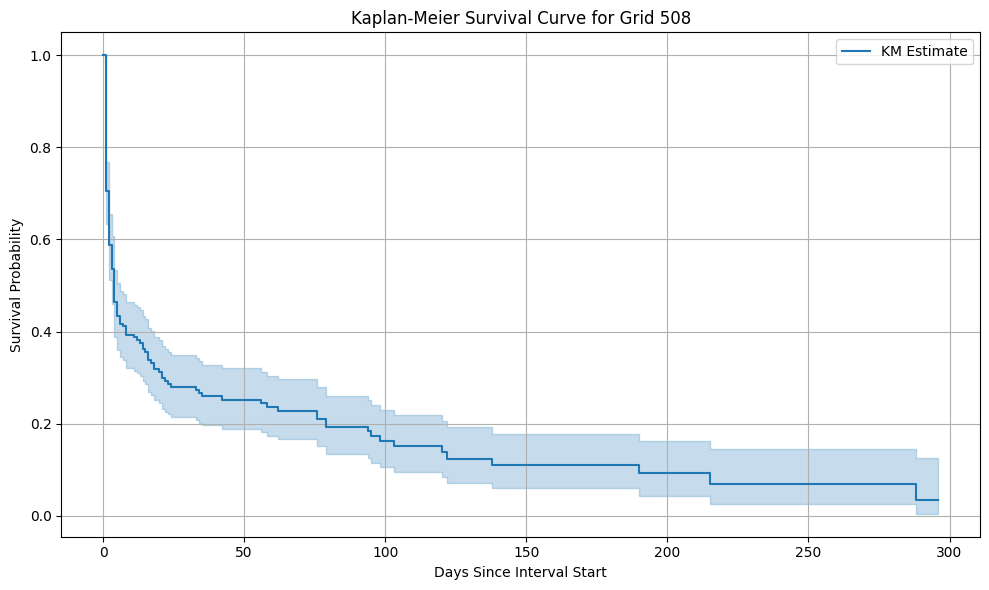

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

#  id=508)
gid = 508
df_grid = event_df[event_df["id"] == gid].copy()

# duration and event
T = df_grid["duration"]
E = df_grid["fire_occurred_x"]  # assumed to be 0/1

# kaplan-Meier fit
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, label="KM Estimate")

# Plot
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title(f"Kaplan-Meier Survival Curve for Grid {gid}")
plt.xlabel("Days Since Interval Start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
def get_monthly_values(df_monthly, grid_id, month, stat_dict=None):
    """
    Retrieves values for temperature, humidity, drought20, wind_speed using stat_dict.

    Parameters:
        df_monthly: DataFrame with columns like 'temperature_q75', etc.
        grid_id: grid cell ID
        month: 1-based month index (1–12)
        stat_dict: dict like {'temperatur': 'q75', 'humidity': 'q25', 'drought_20': 'q25'}

    Returns:
        Dictionary of values for use in model input
    """
    if stat_dict is None:
        stat_dict = {}

    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    row = row.iloc[0]

    def get_value(base, alias=None):
        var_key = alias or base
        stat = stat_dict.get(var_key, "median")
        col = f"{base}_{stat}"
        if col not in row:
            raise KeyError(f"Column {col} not found in df_monthly")
        return row[col]

    return {
        "temperatur":   get_value("temperature"),                 # maps to 'temperatur' in model
        "wind_speed":   get_value("wind_speed"),
        "drought_20":   get_value("drought20", "drought_20"),     
        "humidity":     get_value("humidity"),
    }

## Fire probability map, change numeric variables to get different horizons

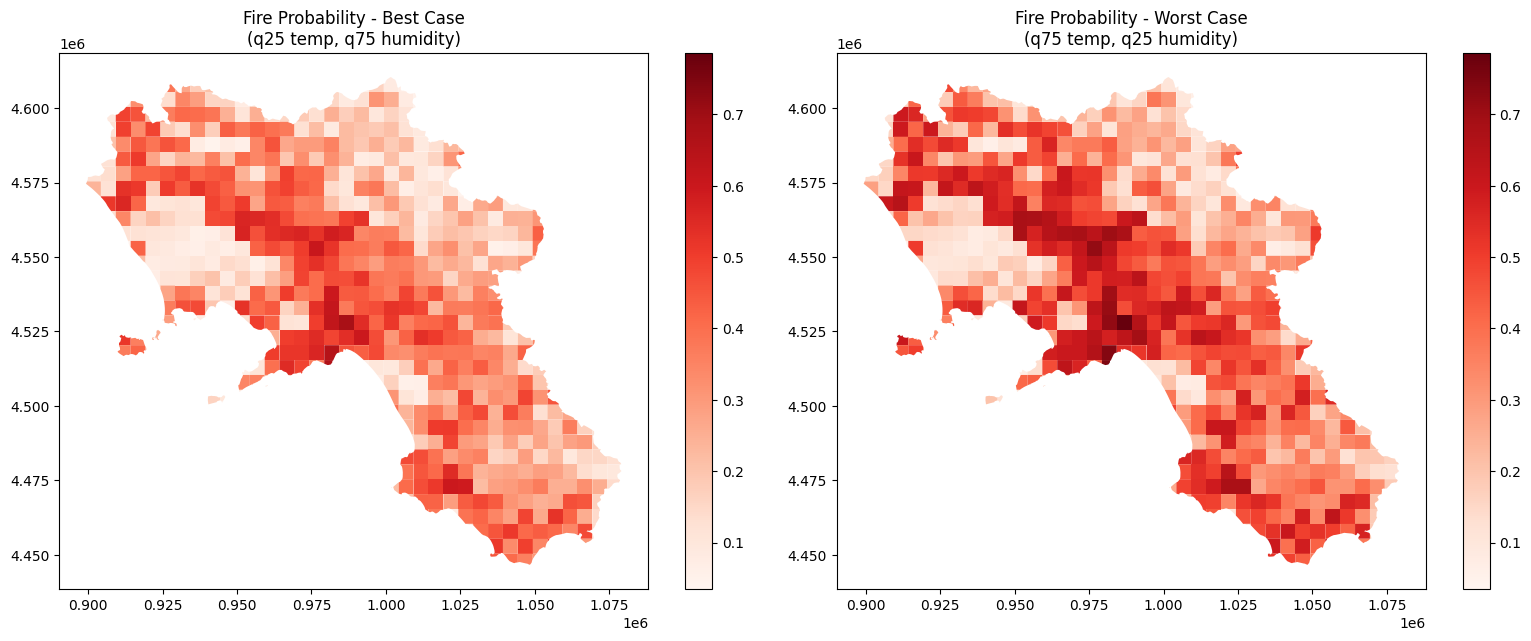

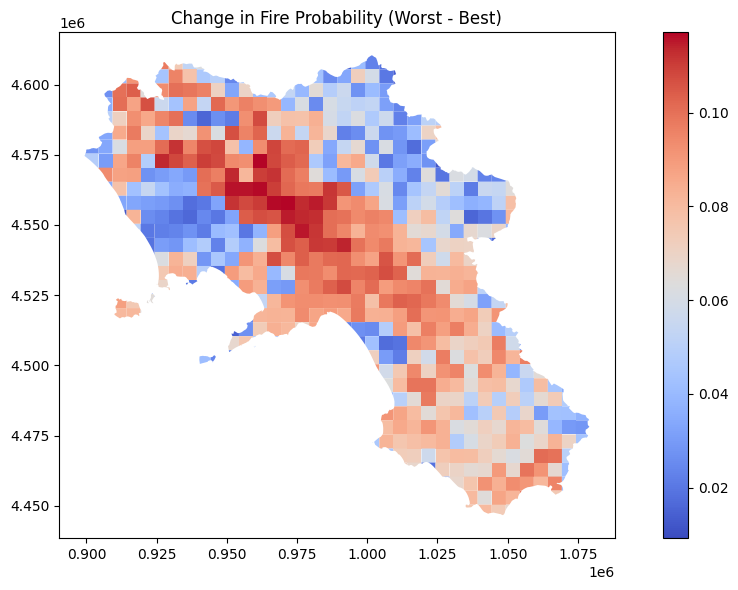

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.ndimage import gaussian_filter1d

def create_fire_probability_map_cox(
    ensemble_models,
    df_split,
    df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict=None,
    stat='median',
    delta_t=15,
    sigma=0.0
):
    """
    For each grid cell, integrate the Cox hazard under time-varying covariates:
      H = sum_k [H0(t_k)-H0(t_{k-1})] * exp(beta^T X(t_k))
    then p_ignition = 1 - exp(-H).
    """
    # ensure GeoDataFrame
    if not isinstance(df_split, gpd.GeoDataFrame):
        df_split = gpd.GeoDataFrame(df_split, geometry="geometry")
    df_split["centroid_x"] = df_split.geometry.centroid.x
    df_split["centroid_y"] = df_split.geometry.centroid.y
    gdf = df_split.drop_duplicates(subset="id").copy()

    # unpack model objects
    model_obj = ensemble_models[0]
    cph       = model_obj["model"]
    scaler    = model_obj["scaler"]
    df_train  = model_obj.get("df_train_raw",
                 model_obj.get("df_train"))
    coords    = model_obj["coords_train"]
    tree      = model_obj["tree_train"]

    # baseline cumulative‐hazard from the CoxPHFitter
    raw_baseline = (cph
        .baseline_cumulative_hazard_
        .reset_index()
        .rename(columns={"index":"time", cph.baseline_cumulative_hazard_.columns[0]:"H0"})
    )

    # feature lists
    features = [
      "temperature","drought20","forest_combined","grass","shrub","forest",
      "neighbor_fire_risk","neighbor_powerline","road","powerline",
      "cos_month","sin_month","temperature_sq","temp_forest_interaction",
      "days_since_last_fire","mean_eleva","agri","humidity","slope30","other","wui"
    ]
    cols_to_scale = [
      "temperature","drought20","forest_combined","days_since_last_fire",
      "neighbor_fire_risk","neighbor_powerline","grass","shrub","agri",
      "mean_eleva","humidity","road","slope30","forest","other","powerline","wui", "cos_month", "sin_month"
    ]

    # default stat lookup
    if stat_dict is None:
        stat_dict = {
            "temperature":"median","humidity":"median",
            "drought20":"median","wind_speed":stat
        }

    predicted = []
    # iterate cells
    for _, cell in gdf.iterrows():
        grid_id = cell["id"]

        # build baseline static row
        baseline = build_baseline_row(df_split, grid_id)

        # time‐grid 0, Δt, 2Δt, …, forecast_horizon
        t_steps = np.arange(0, forecast_horizon+delta_t, delta_t)
        # interpolate H0 at each t
        H0_ts = np.interp(
            t_steps,
            raw_baseline["time"].values,
            raw_baseline["H0"].values,
            right=raw_baseline["H0"].values[-1]
        )
        delta_H0 = np.diff(H0_ts, prepend=0)

        H_cum = 0.0
        # accumulate piecewise
        for k, t in enumerate(t_steps):
            # 1) seasonal day-of-year and days-since-fire
            doy = ((day_of_year - 1) + t) % 365 + 1
            cos_m, sin_m = compute_seasonality_cos_sin(doy)

            # 2) monthly vars at this step
            month = day_to_month(doy)
            mvars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

            # 3) build X(t)
            row = baseline.copy()
            row.update(mvars)
            row["days_since_last_fire"] = days_since_fire + t
            row["cos_month"] = cos_m
            row["sin_month"] = sin_m

            # fill zero‐defaults
            for v in ["powerline","grass","shrub","agri","slope30",
                      "mean_eleva","no_prior_fire","forest","road","other","wui"]:
                row.setdefault(v, 0.0)

            # 4) neighbor features
            row = compute_neighbor_features(row, df_train, coords, tree, neighbor_radius)
            row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
            row["road_combined"]   = (row["road"]   + row["neighbor_road"])   / 2
            row["temperature_sq"]         = row["temperature"]**2
            row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]

            # 5) scale & assemble X_final
            X_temp = pd.DataFrame([row])
            X_scaled = X_temp.copy()
            X_scaled[cols_to_scale] = scaler.transform(X_temp[cols_to_scale])
            X_final = X_scaled[features]

            # 6) get multiplier exp(xβ)
            lp = cph.predict_log_partial_hazard(X_final).iloc[0]
            mult = np.exp(lp)

            # 7) accumulate hazard
            H_cum += delta_H0[k] * mult

        # final ignition probability
        p_ign = 1.0 - np.exp(-H_cum)
        predicted.append(p_ign)

    gdf["predicted_prob"] = predicted

    # optional smoothing across cells in map (not shown) or return directly
    return gdf


# scenario definitions
stat_dict_best = {
    "temperature": "q25", "humidity": "q75", "drought_20": "q75", "wind_speed": "median"
}
stat_dict_worst = {
    "temperature": "q75", "humidity": "q25", "drought_20": "q25", "wind_speed": "median"
}

# generate maps 
gdf_map_best = create_fire_probability_map_cox(
    ensemble_models=ensemble_models,
    df_split=df_split,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict=stat_dict_best
)

gdf_map_worst = create_fire_probability_map_cox(
    ensemble_models=ensemble_models,
    df_split=df_split,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict=stat_dict_worst
)

# color scale 
vmin = min(gdf_map_best["predicted_prob"].min(), gdf_map_worst["predicted_prob"].min())
vmax = max(gdf_map_best["predicted_prob"].max(), gdf_map_worst["predicted_prob"].max())


# vmax = 0.8

# plot side-by-side 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

gdf_map_best.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title("Fire Probability - Best Case\n(q25 temp, q75 humidity)")

gdf_map_worst.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title("Fire Probability - Worst Case\n(q75 temp, q25 humidity)")

plt.tight_layout()
plt.show()

# --- Optional: Difference map ---
gdf_diff = gdf_map_worst.copy()
gdf_diff["delta"] = gdf_map_worst["predicted_prob"] - gdf_map_best["predicted_prob"]

fig, ax = plt.subplots(figsize=(10, 6))
gdf_diff.plot(column="delta", cmap="coolwarm", legend=True, ax=ax)
ax.set_title("Change in Fire Probability (Worst - Best)")
plt.tight_layout()
plt.show()


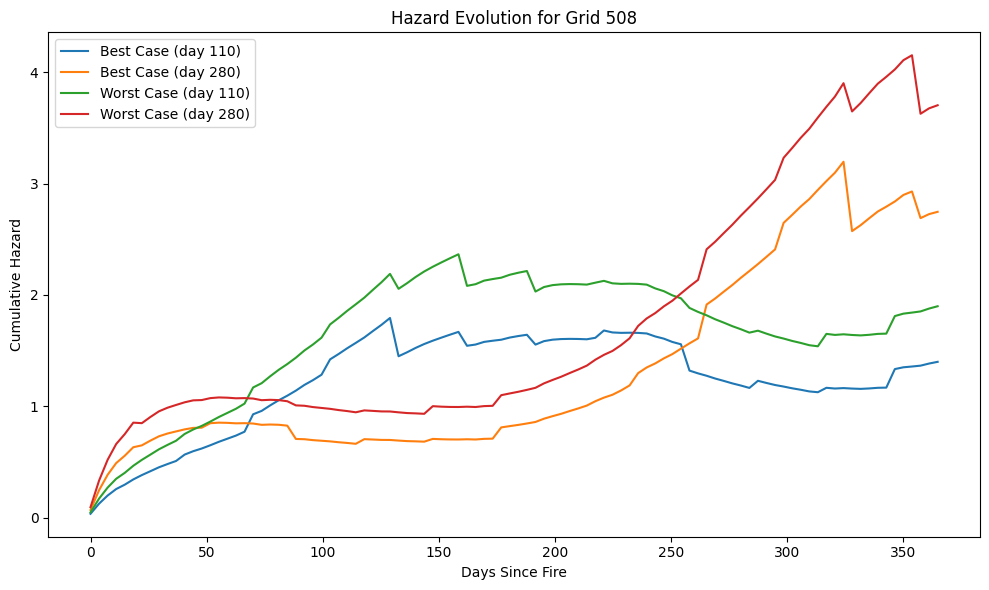

In [30]:
def compare_fire_timing_overlay_cox(
    ensemble_models,
    df_split,
    df_monthly,
    grid_id,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=None,
    scenario_labels=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "forest",
        "neighbor_fire_risk", "neighbor_powerline", "road", "powerline",
        "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction",
        "days_since_last_fire", "mean_eleva", "agri", "humidity", "slope30",
        "other", "wui"
    ]
    cols_to_scale = [
        "temperature", "drought20", "forest_combined", "days_since_last_fire",
        "neighbor_fire_risk", "neighbor_powerline", "grass", "shrub", "agri",
        "mean_eleva", "humidity", "road", "slope30", "forest", "other",
        "powerline", "wui"
    ]
    derived_features = ["cos_month", "sin_month", "temperature_sq", "temp_forest_interaction"]

    forecast_times = np.linspace(0, forecast_horizon, 100)
    model_obj = ensemble_models[0]
    cox_model = model_obj["model"]
    df_train = model_obj["df_train_raw"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]
    scaler = model_obj["scaler"]

    baseline = build_baseline_row(df_split, grid_id)

    if stat_dicts is None:
        stat_dicts = [
            {"temperature": "q25", "humidity": "q75", "drought_20": "q75", "wind_speed": "median"},
            {"temperature": "q75", "humidity": "q25", "drought_20": "q25", "wind_speed": "median"},
        ]
    if scenario_labels is None:
        scenario_labels = ["Best Case", "Worst Case"]

    plt.figure(figsize=(10, 6))

    for stat_dict, label in zip(stat_dicts, scenario_labels):
        for init_day in initial_day_values:
            hazard_curve = []
            for t in forecast_times:
                day_t = (init_day + t) % 365
                month = day_to_month(day_t)
                cos_month, sin_month = compute_seasonality_cos_sin(day_t)

                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

                row = baseline.copy()
                row.update(monthly_vars)
                row["days_since_last_fire"] = days_since_fire
                row["cos_month"] = cos_month
                row["sin_month"] = sin_month

                row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)
                row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
                row["temperature_sq"] = row["temperature"] ** 2
                row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]

                for f in features:
                    if f not in row:
                        row[f] = 0.0

                X_temp = pd.DataFrame([row])
                X_scaled = pd.DataFrame(scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale)
                X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
                X_final = X_final[features]

                surv_func = cox_model.predict_survival_function(X_final).iloc[:, 0]
                clamped_time = min(t, surv_func.index[-1])
                surv_prob = float(surv_func.loc[surv_func.index >= clamped_time].iloc[0])
                hazard = -np.log(np.clip(surv_prob, 1e-6, 1.0))
                hazard_curve.append(hazard)

            plt.plot(forecast_times, hazard_curve, label=f"{label} (day {init_day})")

    plt.xlabel("Days Since Fire")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution for Grid {grid_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()
compare_fire_timing_overlay_cox(
    ensemble_models=ensemble_models,
    df_split=df_split,
    df_monthly=df_monthly,
    grid_id=508,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=[
        {"temperature": "q25", "humidity": "q75", "drought_20": "q75"},
        {"temperature": "q75", "humidity": "q25", "drought_20": "q25"}
    ],
    scenario_labels=["Best Case", "Worst Case"]
)


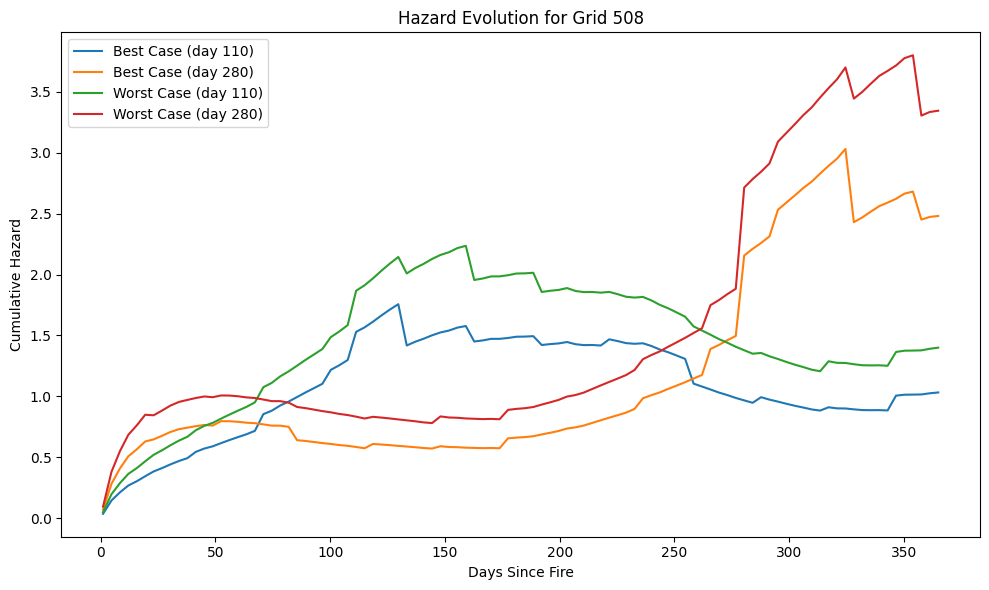

In [ ]:
df_split["centroid_x"] = df_split["geometry"].apply(lambda g: g.centroid.x)
df_split["centroid_y"] = df_split["geometry"].apply(lambda g: g.centroid.y)
def compare_fire_timing_overlay_cox(
    ensemble_models,
    df_split,
    df_monthly,
    grid_id,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=None,
    scenario_labels=None
):

    features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "forest",
        "neighbor_fire_risk", "neighbor_powerline", "road", "powerline",
        "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction",
        "days_since_last_fire", "mean_eleva", "agri", "humidity", "slope30",
        "other", "wui"
    ]
    cols_to_scale = [
        "temperature", "drought20", "forest_combined", "days_since_last_fire",
        "neighbor_fire_risk", "neighbor_powerline", "grass", "shrub", "agri",
        "mean_eleva", "humidity", "road", "slope30", "forest", "other",
        "powerline", "wui"
    ]
    derived_features = ["cos_month", "sin_month", "temperature_sq", "temp_forest_interaction"]

    forecast_times = np.linspace(1, forecast_horizon, 100)
    model_obj = ensemble_models[0]
    cox_model = model_obj["model"]
    df_train = model_obj["df_train_raw"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]
    scaler = model_obj["scaler"]

    baseline = build_baseline_row(df_split, grid_id)
    base_dsf = baseline.get("days_since_last_fire", 0)


    if stat_dicts is None:
        stat_dicts = [
            {"temperature": "q25", "humidity": "q75", "drought_20": "q75", "wind_speed": "median"},
            {"temperature": "q75", "humidity": "q25", "drought_20": "q25", "wind_speed": "median"},
        ]
    if scenario_labels is None:
        scenario_labels = ["Best Case", "Worst Case"]

    plt.figure(figsize=(10, 6))

    for stat_dict, label in zip(stat_dicts, scenario_labels):
        for init_day in initial_day_values:
            hazard_curve = []
            for t in forecast_times:
                day_t = (init_day + t) % 365
                month = day_to_month(day_t)
                cos_month, sin_month = compute_seasonality_cos_sin(day_t)

                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

                row = baseline.copy()
                row.update(monthly_vars)
                if t < init_day:
                    # pre‐fire: just accrue from the baseline
                    row["days_since_last_fire"] = base_dsf + t
                else:
                    # post‐fire: reset clock at t = init_day
                    row["days_since_last_fire"] = t - init_day

                row["cos_month"] = cos_month
                row["sin_month"] = sin_month

                row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)
                row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
                row["temperature_sq"] = row["temperature"] ** 2
                row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]

                for f in features:
                    if f not in row:
                        row[f] = 0.0

                X_temp = pd.DataFrame([row])
                X_scaled = pd.DataFrame(scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale)
                X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
                X_final = X_final[features]

                surv_func = cox_model.predict_survival_function(X_final).iloc[:, 0]
                clamped_time = min(t, surv_func.index[-1])
                surv_prob = float(surv_func.loc[surv_func.index >= clamped_time].iloc[0])
                hazard = -np.log(np.clip(surv_prob, 1e-6, 1.0))
                hazard_curve.append(hazard)

            plt.plot(forecast_times, hazard_curve, label=f"{label} (day {init_day})")

    plt.xlabel("Days Since Fire")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution for Grid {grid_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()
compare_fire_timing_overlay_cox(
    ensemble_models=ensemble_models,
    df_split=df_split,
    df_monthly=df_monthly,
    grid_id=508,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=[
        {"temperature": "q25", "humidity": "q75", "drought_20": "q75"},
        {"temperature": "q75", "humidity": "q25", "drought_20": "q25"}
    ],
    scenario_labels=["Best Case", "Worst Case"]
)


## RSF model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from scipy.spatial import cKDTree

# Temporal cutoff: ~12 years
TEMPORAL_CUTOFF = 4053
NEIGHBOR_RADIUS = 5000

# Temporal split
df_train = df_split[df_split["start_time"] < TEMPORAL_CUTOFF].copy()
df_test = df_split[df_split["start_time"] >= TEMPORAL_CUTOFF].copy()

# Basic preprocessing
for df in [df_train, df_test]:
    df["centroid_x"] = df["geometry"].apply(lambda g: g.centroid.x)
    df["centroid_y"] = df["geometry"].apply(lambda g: g.centroid.y)
    df["duration"] = df["stop_time"] - df["start_time"]
    df["ruggedness"] = df["max_elevat"] - df["mean_eleva"]
    df["elevation_ruggedness_index"] = df["ruggedness"] * df["mean_eleva"]
    df["log_days_since_last_fire"] = np.log1p(df["days_since_last_fire"])

coords_train = df_train[["centroid_x", "centroid_y"]].values
tree_train = cKDTree(coords_train)

neighbor_features = [
    "neighbor_fire_risk", "neighbor_forest", "neighbor_road",
    "neighbor_powerline"
]

# Initialize neighbor features
for df in [df_train, df_test]:
    for f in neighbor_features:
        df[f] = np.nan


lag_days = 10  # or adjust to your preference
coords_train = df_train[["centroid_x", "centroid_y"]].values
coords_test  = df_test[["centroid_x",  "centroid_y"]].values
tree_train   = cKDTree(coords_train)

# TRAIN SET — uses historical neighbors only (with lag)
for i, pt in enumerate(coords_train):
    my_start = df_train.iloc[i]["start_time"]
    all_nb = tree_train.query_ball_point(pt, NEIGHBOR_RADIUS)
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_train.iloc[past_nb]
    dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_train.loc[df_train.index[i], "neighbor_fire_risk"]  = sub["fire_occurred_x"].sum() / sub["duration"].sum()
    df_train.loc[df_train.index[i], "neighbor_forest"]     = np.average(sub["forest"], weights=w)
    df_train.loc[df_train.index[i], "neighbor_road"]       = np.average(sub["road"], weights=w)
    df_train.loc[df_train.index[i], "neighbor_powerline"]  = np.average(sub["powerline"], weights=w)

# TEST SET — use only TRAIN history
for i, pt in enumerate(coords_test):
    my_start = df_test.iloc[i]["start_time"]
    all_nb = tree_train.query_ball_point(pt, NEIGHBOR_RADIUS)
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_train.iloc[past_nb]
    dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_test.loc[df_test.index[i], "neighbor_fire_risk"]  = sub["fire_occurred_x"].sum() / sub["duration"].sum()
    df_test.loc[df_test.index[i], "neighbor_forest"]     = np.average(sub["forest"], weights=w)
    df_test.loc[df_test.index[i], "neighbor_road"]       = np.average(sub["road"], weights=w)
    df_test.loc[df_test.index[i], "neighbor_powerline"]  = np.average(sub["powerline"], weights=w)

# Fill remaining NaNs
neighbor_features = ["neighbor_forest", "neighbor_road", "neighbor_powerline"]
for df in [df_train, df_test]:
    df[neighbor_features] = df[neighbor_features].fillna(df_train[neighbor_features].median())
    df["neighbor_fire_risk"] = df["neighbor_fire_risk"].fillna(0.0)

# Derived Features
for df in [df_train, df_test]:
    df["forest_combined"] = (df["forest"] + df["neighbor_forest"]) / 2
    df["road_combined"] = (df["road"] + df["neighbor_road"]) / 2
    df["temperature_sq"] = df["temperature"] ** 2
    # df["wind_speed_sq"] = df["wind_speed"] ** 2
    df["temp_forest_interaction"] = df["temperature"] * df["forest_combined"]
    df["dsf_x_no_prior"] = df["days_since_last_fire"] * df["no_prior_fire"]

cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction"
]

scaler = MinMaxScaler()
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

# RSF Model
rsf_features = cols_to_scale 

df_train["fire_occurred_x"] = df_train["fire_occurred_x"].astype(bool)
df_test["fire_occurred_x"] = df_test["fire_occurred_x"].astype(bool)

y_train = Surv.from_dataframe("fire_occurred_x", "duration", df_train)
y_test = Surv.from_dataframe("fire_occurred_x", "duration", df_test)

rsf = RandomSurvivalForest(n_estimators=400, min_samples_split=10, min_samples_leaf=10,
                           max_features=0.05, n_jobs=-1, random_state=12)
rsf.fit(df_train[rsf_features], y_train)

train_pred = rsf.predict(df_train[rsf_features])
test_pred = rsf.predict(df_test[rsf_features])

train_c_index = concordance_index_censored(y_train["fire_occurred_x"], y_train["duration"], train_pred)[0]
test_c_index = concordance_index_censored(y_test["fire_occurred_x"], y_test["duration"], test_pred)[0]

print(f"Train C-index: {train_c_index:.4f}")
print(f"Test C-index: {test_c_index:.4f}")


Train C-index: 0.8639
Test C-index: 0.8648


In [ ]:
import numpy as np
from sksurv.metrics import concordance_index_censored


# risk scores from fitted CoxPH model
cox_risks = cph.predict_partial_hazard(df_test_final).values  
# predictions from fitted RSF model
rsf_risks = rsf.predict( df_test[rsf_features].reset_index(drop=True) )  

durations = df_test["duration"].values
events    = df_test["fire_occurred_x"].values.astype(bool)
n_obs     = len(durations)

# choose a smaller bootstrap count if you like (500–1000 is often plenty)
n_boot = 1000  
diffs  = np.empty(n_boot)

rng = np.random.default_rng(42)
for i in range(n_boot):
    idxs = rng.integers(0, n_obs, n_obs)          # fast vectorized draw
    # compute C-index by slicing precomputed risks
    ci_cox = concordance_index_censored(events[idxs], durations[idxs], cox_risks[idxs])[0]
    ci_rsf = concordance_index_censored(events[idxs], durations[idxs], rsf_risks[idxs])[0]
    diffs[i] = ci_rsf - ci_cox

# get your point estimate + 95% CI
lower, upper = np.percentile(diffs, [2.5, 97.5])
mean_diff    = diffs.mean()

print(f"\nBootstrap ΔC-index (RSF - CoxPH) = {mean_diff:.3f}")
print(f"95% CI = [{lower:.3f}, {upper:.3f}]")



Bootstrap ΔC-index (RSF – CoxPH) = 0.025
95% CI = [0.019, 0.030]


Permutation‐based feature importances:
                    feature  mean_importance  std_importance
0      days_since_last_fire     3.914520e-02        0.003499
1                  humidity     7.070541e-03        0.001613
2                 cos_month     4.768657e-03        0.001401
3                 drought20     4.109092e-03        0.003538
4                 sin_month     3.403357e-03        0.003325
5                       wui     2.704218e-03        0.001194
6             no_prior_fire     2.532731e-03        0.000777
7                     shrub     2.087524e-03        0.000811
8                night_ligh     1.988590e-03        0.001031
9                      road     1.437852e-03        0.000678
10       neighbor_fire_risk     1.296046e-03        0.000897
11                powerline     1.282855e-03        0.000833
12                     agri     1.236685e-03        0.000373
13       neighbor_powerline     1.114665e-03        0.001030
14                    grass     8.937110e-04  

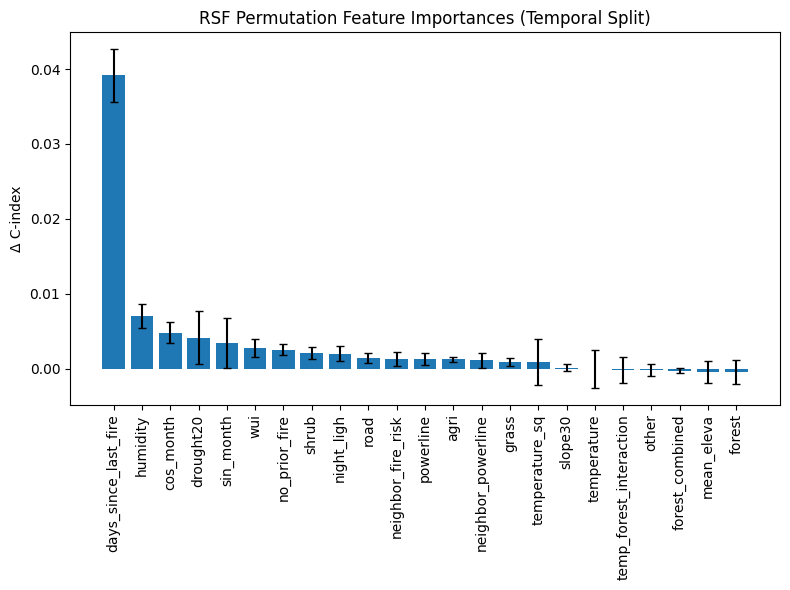

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

# 1) define a C-index scorer for RSF
def rsf_scorer(estimator, X, y_struct):
    # y_struct has fields ('fire_occurred_x','duration')
    event, time = y_struct["fire_occurred_x"], y_struct["duration"]
    preds = estimator.predict(X)  # returns risk scores
    return concordance_index_censored(event, time, preds)[0]

# 2) prepare test data and optional subsample
X_test = df_test[rsf_features]
y_test = y_test  # your structured array from before

if len(X_test) > 500:
    X_sub = X_test.sample(500, random_state=0)
    idx = X_test.index.get_indexer(X_sub.index)
    y_sub = y_test[idx]
else:
    X_sub, y_sub = X_test, y_test

# 3) run permutation importance
perm_res = permutation_importance(
    rsf,
    X_sub,
    y_sub,
    scoring=rsf_scorer,
    n_repeats=5,
    random_state=42,
    n_jobs=1
)

# 4) collect into a DataFrame
perm_imp = (
    pd.DataFrame({
        "feature":         rsf_features,
        "mean_importance": perm_res.importances_mean,
        "std_importance":  perm_res.importances_std
    })
    .sort_values("mean_importance", ascending=False)
    .reset_index(drop=True)
)

print("Permutation-based feature importances:")
print(perm_imp)

# 5) plot
plt.figure(figsize=(8,6))
plt.bar(
    perm_imp["feature"],
    perm_imp["mean_importance"],
    yerr=perm_imp["std_importance"],
    capsize=3
)
plt.xticks(rotation=90)
plt.ylabel("Δ C-index")
plt.title("RSF Permutation Feature Importances (Temporal Split)")
plt.tight_layout()
plt.show()


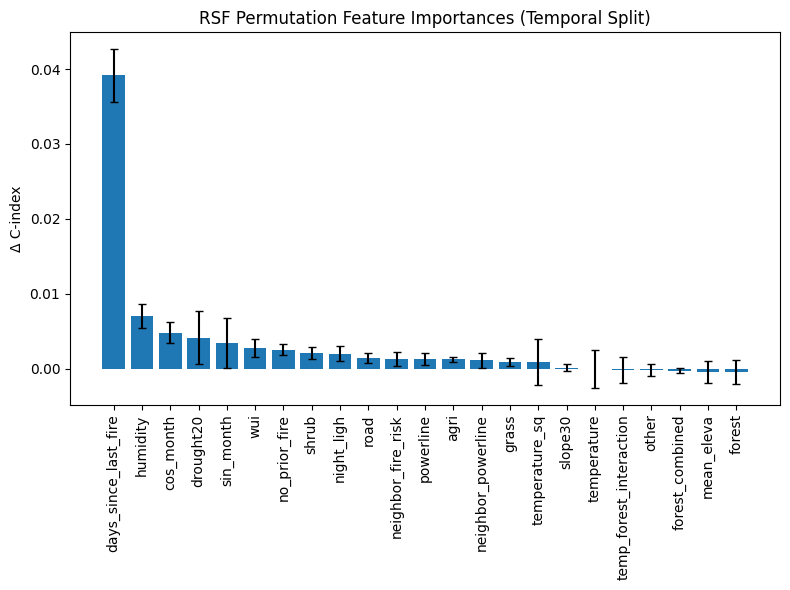

In [ ]:
#  plot
plt.figure(figsize=(8,6))
plt.bar(
    perm_imp["feature"],
    perm_imp["mean_importance"],
    yerr=perm_imp["std_importance"],
    capsize=3
)
plt.xticks(rotation=90)
plt.ylabel("Δ C-index")
plt.title("RSF Permutation Feature Importances (Temporal Split)")
plt.tight_layout()
plt.show()

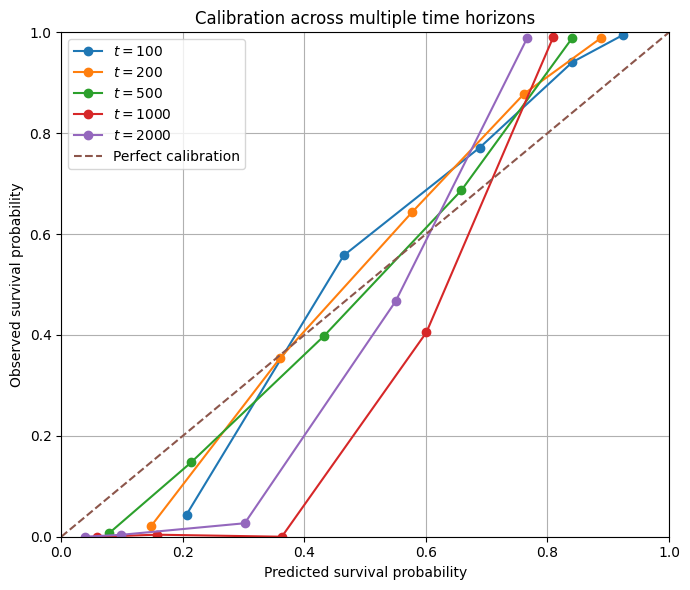

In [26]:
from sksurv.nonparametric import kaplan_meier_estimator

X_test = df_test[rsf_features]
df_te  = df_test.copy()

# Predict full survival curves for each test sample
surv_funcs = rsf.predict_survival_function(X_test)

# Attach the list of step functions to df_te
df_te["pred_surv_curve"] = surv_funcs

# Calibration plot
plt.figure(figsize=(7, 6))

for t_hor in time_horizons:
    # Evaluate each survival function at t_hor
    df_te["pred_surv"] = df_te["pred_surv_curve"].apply(lambda fn: fn(t_hor))
    df_te["risk_bin"] = pd.qcut(df_te["pred_surv"], q=n_bins, labels=False)

    pred_vals = []
    obs_vals  = []

    for b in range(n_bins):
        bin_group = df_te[df_te["risk_bin"] == b]
        if len(bin_group) < 5:
            continue
        # mean predicted survival
        pred_vals.append(bin_group["pred_surv"].mean())

        # KM estimate of observed survival at t_hor
        times, probs = kaplan_meier_estimator(
            bin_group["fire_occurred_x"].values, 
            bin_group["duration"].values
        )
        obs_vals.append(np.interp(t_hor, times, probs))

    plt.plot(pred_vals, obs_vals, marker="o", label=f"$t = {t_hor}$")

# Perfect calibration line
plt.plot([0, 1], [0, 1], "--", label="Perfect calibration")

plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration across multiple time horizons")
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Integrated Brier Score (IBS): 0.1113 ± 0.0046


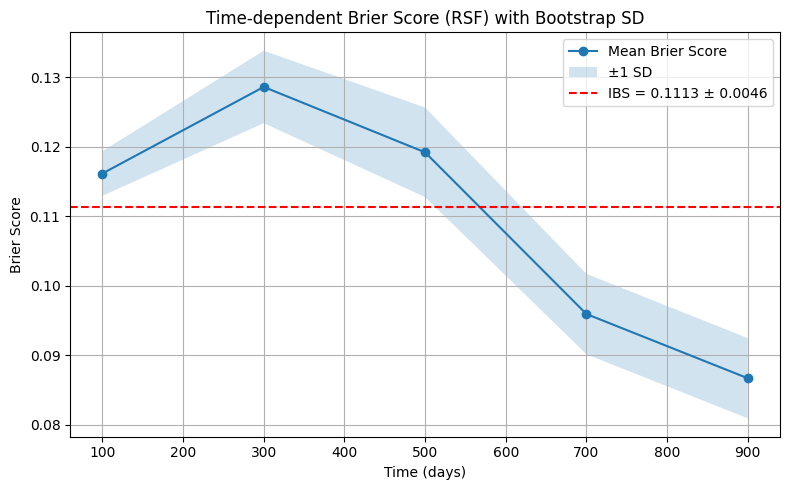

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score
from sksurv.util import Surv

#  evaluation times
eval_times = np.arange(100, 1000, 200)

# batched survival‐function prediction
def get_sf_at_times(model, X, times, batch_size=1000):
    results = []
    for i in range(0, len(X), batch_size):
        Xb = X.iloc[i : i+batch_size]
        sf_list = model.predict_survival_function(Xb)
        sf_batch = np.asarray([
            [fn(t) if t <= fn.x[-1] else fn.y[-1] for t in times]
            for fn in sf_list
        ])
        results.append(sf_batch)
    return np.vstack(results)

# 3. Precompute the full‐test survival‐matrix
sf_full = get_sf_at_times(rsf, X_test, eval_times)
n_test  = sf_full.shape[0]
n_times = sf_full.shape[1]

# 5. Bootstrap Brier curves
n_boot = 200
all_bs = np.zeros((n_boot, n_times))
idxs   = np.arange(n_test)

for b in range(n_boot):
    boot_idx     = np.random.choice(idxs, size=n_test, replace=True)
    y_test_b     = y_test_struct[boot_idx]    # use the structured array directly
    sf_b         = sf_full[boot_idx, :]
    _, bs_curve  = brier_score(y_train_struct, y_test_b, sf_b, eval_times)
    all_bs[b, :] = bs_curve

# 6. Aggregate
mean_bs = all_bs.mean(axis=0)
std_bs  = all_bs.std(axis=0, ddof=1)

# IBS: integrate each bootstrap, then summarize
ibs_boot = np.trapezoid(all_bs, eval_times, axis=1) / (eval_times[-1] - eval_times[0])
ibs_mean = ibs_boot.mean()
ibs_std  = ibs_boot.std(ddof=1)

print(f"Integrated Brier Score (IBS): {ibs_mean:.4f} ± {ibs_std:.4f}")

# 7. Plot with ±1 SD band
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 SD")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"IBS = {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.title("Time-dependent Brier Score (RSF) with Bootstrap SD")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## contour plot for rsf

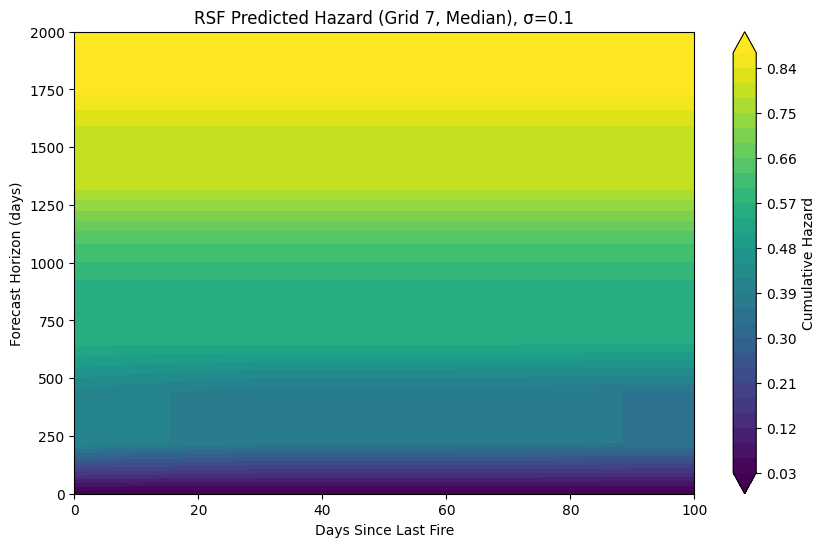

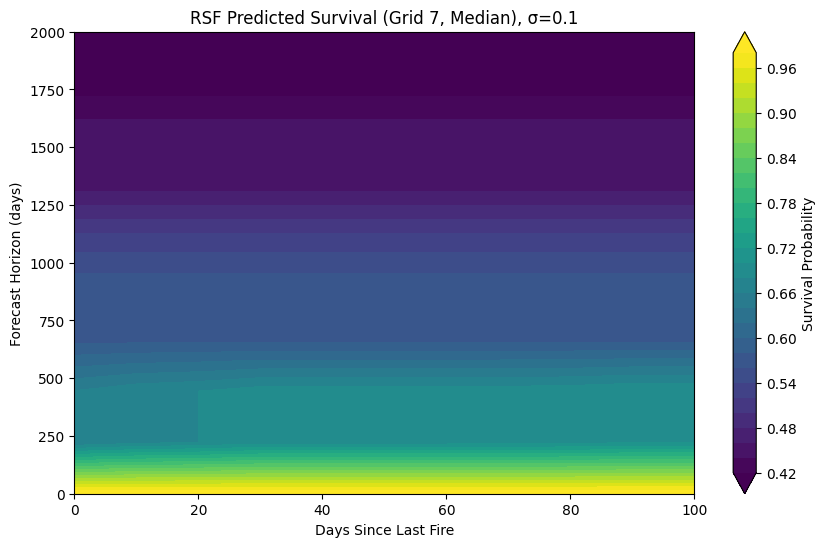

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import geopandas as gpd


def predict_and_plot_with_survival(rsf,
                               df_train,
                               coords_train,
                               tree_train,
                               scaler,
                               event_df,
                               df_monthly,
                               grid_id,
                               statistic='median',
                               neighbor_radius=5000,
                               sigma=0.1,
                               delta_t=10):
    """
    Predict and plot cumulative hazard and survival probability over a grid of
    "days since last fire" (x-axis) vs. forecast horizon (y-axis), using
    piecewise accumulation of hazard with evolving covariates.
    """
    # Ensure GeoDataFrame for events
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')
    if 'centroid_x' not in event_df.columns:
        event_df['centroid_x'] = event_df.geometry.centroid.x
        event_df['centroid_y'] = event_df.geometry.centroid.y

    # Define feature lists
    rsf_features = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "cos_month", "sin_month","temperature_sq", "temp_forest_interaction"
    ]
    cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "cos_month", "sin_month","temperature_sq", "temp_forest_interaction"
    ]
    derived = []

    # Ranges
    dsf_range = np.arange(0, 101, delta_t)
    forecast_range = np.linspace(0, 2000, 10)

    hazard_mat = np.zeros((len(forecast_range), len(dsf_range)))
    surv_mat = np.zeros_like(hazard_mat)

    baseline = build_baseline_row(event_df, grid_id)
    ensemble = [rsf]

    eps = 1e-10
    for i, T in enumerate(forecast_range):
        for j, dsf in enumerate(dsf_range):
            cum_h = 0.0
            prev_S = 1.0

            # step through time
            times = np.arange(0, T + delta_t, delta_t)
            for t in times:
                # update covariates
                row = baseline.copy()
                row['days_since_last_fire'] = dsf + t  # dsf increases as time passes
                month = day_to_month(t % 365)
                mvars = get_monthly_values(df_monthly, grid_id, month, stat=statistic)
                row.update(mvars)
                cos_m, sin_m = compute_seasonality_cos_sin(t)
                row['cos_month'], row['sin_month'] = cos_m, sin_m
                # fixed
                for var in ['powerline', 'grass', 'shrub', 'agri', 'mean_eleva', 'no_prior_fire']:
                    row.setdefault(var, baseline.get(var, 0.0))
                # neighbor
                row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)
                # engineered
                row['forest_combined'] = (row['forest'] + row['neighbor_forest']) / 2
                row['road_combined']   = (row['road']   + row['neighbor_road'])   / 2
                row['temperature_sq']  = row['temperature'] ** 2
                row['temp_forest_interaction'] = row['temperature'] * row['forest_combined']

                X = pd.DataFrame([row])
                Xs = pd.DataFrame(scaler.transform(X[cols_to_scale]), columns=cols_to_scale)
                Xf = pd.concat([Xs, X[derived].reset_index(drop=True)], axis=1)[rsf_features]

                # predict
                surv_vals = []
                for model in ensemble:
                    fn = model.predict_survival_function(Xf)[0]
                    surv_vals.append(fn(t))
                S_t = min(np.mean(surv_vals), prev_S)
                if S_t <= 0 or np.isnan(S_t):
                    continue
                # delta hazard
                dH = -np.log(S_t + eps) + np.log(prev_S + eps)
                cum_h += dH
                prev_S = S_t

            H = cum_h
            S = np.exp(-H)
            hazard_mat[i, j] = H
            surv_mat[i, j] = S

    # smooth
    Hs = gaussian_filter(hazard_mat, sigma=sigma)
    Ss = gaussian_filter(surv_mat, sigma=sigma)
    Xp, Yp = np.meshgrid(dsf_range, forecast_range)

    # plot
    for mat, label, title_suffix in [
        (Hs, 'Cumulative Hazard', 'Hazard'),
        (Ss, 'Survival Probability', 'Survival')]:
        plt.figure(figsize=(10, 6))
        plt.contourf(Xp, Yp, mat, levels=30, extend='both')
        plt.colorbar(label=label)
        plt.xlabel('Days Since Last Fire')
        plt.ylabel('Forecast Horizon (days)')
        plt.title(f"RSF Predicted {title_suffix} (Grid {grid_id}, {statistic.title()}), σ={sigma}")
        plt.xlim(dsf_range[0], dsf_range[-1])
        plt.show()

predict_and_plot_with_survival(rsf, df_train, coords_train, tree_train, scaler, df_split, df_monthly,
                               grid_id=7, statistic='median', neighbor_radius=5000)



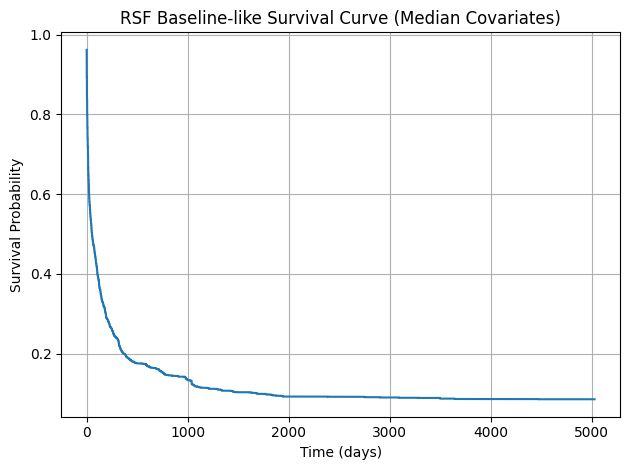

In [23]:
from sksurv.functions import StepFunction

# Get a "neutral" input row — e.g., median across features
neutral_row = pd.DataFrame([df_train[rsf_features].median().values], columns=rsf_features)

# Predict survival function
surv_fn_list = rsf.predict_survival_function(neutral_row, return_array=False)

# Example: Plot for first (and only) entry
import matplotlib.pyplot as plt

surv_fn: StepFunction = surv_fn_list[0]
plt.step(surv_fn.x, surv_fn.y)
plt.title("RSF Baseline-like Survival Curve (Median Covariates)")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


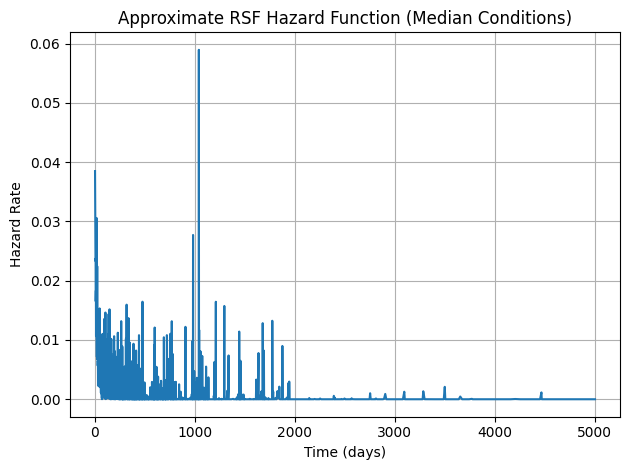

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Extract time (x) and survival probability (y)
t = surv_fn.x
s = surv_fn.y

# Approximate the hazard: h(t) ≈ -ΔS / Δt / S(t)
delta_s = -np.diff(s)
delta_t = np.diff(t)
hazard = delta_s / delta_t / s[:-1]

# Midpoints of time bins
t_mid = (t[1:] + t[:-1]) / 2

# Plot hazard
plt.plot(t_mid, hazard)
plt.title("Approximate RSF Hazard Function (Median Conditions)")
plt.xlabel("Time (days)")
plt.ylabel("Hazard Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Define spike window (e.g., ±50 days around day 1000)
window_center = 1320
window_width = 50

# Merge back for full coverage (optionally include only relevant columns)
df_scaled_all = pd.concat([df_train, df_test], axis=0)

# Apply the same spike window
spike_scaled = df_scaled_all[
    (df_scaled_all["start_time"] <= window_center + window_width) &
    (df_scaled_all["stop_time"] >= window_center - window_width)
].copy()

# Compare to surrounding (wider window, excluding spike)
background_scaled = df_scaled_all[
    (df_scaled_all["start_time"] <= window_center + 3 * window_width) &
    (df_scaled_all["stop_time"] >= window_center - 3 * window_width) &
    ~df_scaled_all.index.isin(spike_scaled.index)
].copy()

# Define scaled feature names
scaled_features = ["temperature", "days_since_last_fire", "drought20", "humidity"]

# Summary comparison
print("Spike Window (Scaled):")
print(spike_scaled[scaled_features].describe().T)

print("\nBackground (Scaled):")
print(background_scaled[scaled_features].describe().T)




Spike Window (Scaled):
                       count      mean       std       min       25%  \
temperature           1204.0  0.602211  0.183020  0.010190  0.463904   
days_since_last_fire  1204.0  0.111296  0.156894  0.000000  0.000204   
drought20             1204.0  0.096019  0.123496  0.000203  0.013888   
humidity              1204.0  0.042790  0.016651  0.004108  0.030245   

                           50%       75%       max  
temperature           0.671948  0.744462  0.930177  
days_since_last_fire  0.018080  0.219612  0.994280  
drought20             0.050882  0.139728  0.980207  
humidity              0.041570  0.054196  0.090208  

Background (Scaled):
                      count      mean       std       min       25%       50%  \
temperature           282.0  0.466581  0.163335  0.129675  0.356377  0.426585   
days_since_last_fire  282.0  0.120467  0.113092  0.000000  0.021502  0.115117   
drought20             282.0  0.155101  0.134630  0.000935  0.059877  0.126969   
humid

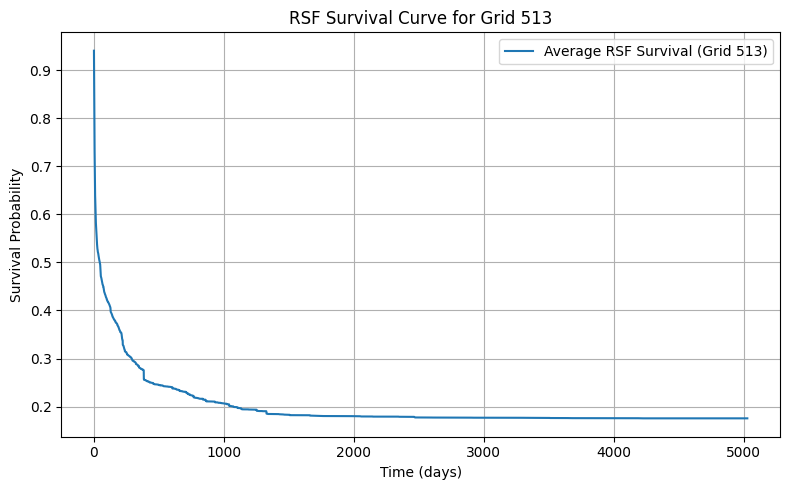

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Filter training data for Grid 513
df_513 = df_train[df_train["id"] == 513].copy()
X_513 = df_513[rsf_features]

# Predict survival functions for each row
surv_funcs_513 = rsf.predict_survival_function(X_513)

# Average survival probability across all instances
avg_surv_513 = np.mean([fn.y for fn in surv_funcs_513], axis=0)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(surv_funcs_513[0].x, avg_surv_513, label="Average RSF Survival (Grid 513)")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("RSF Survival Curve for Grid 513")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Deep.surv

0:	[1s / 1s],		train_loss: 3.5007,	val_loss: 7.1074
1:	[1s / 3s],		train_loss: 3.2784,	val_loss: 6.9198
2:	[1s / 4s],		train_loss: 3.1739,	val_loss: 6.7913
3:	[1s / 6s],		train_loss: 3.0989,	val_loss: 6.7102
4:	[1s / 7s],		train_loss: 3.0454,	val_loss: 6.6851
5:	[1s / 9s],		train_loss: 3.0198,	val_loss: 6.6633
6:	[1s / 11s],		train_loss: 2.9990,	val_loss: 6.6135
7:	[1s / 12s],		train_loss: 2.9822,	val_loss: 6.6213
8:	[1s / 14s],		train_loss: 2.9482,	val_loss: 6.5866
9:	[1s / 15s],		train_loss: 2.9511,	val_loss: 6.5449
10:	[1s / 17s],		train_loss: 2.9249,	val_loss: 6.5102
11:	[1s / 18s],		train_loss: 2.9132,	val_loss: 6.5234
12:	[1s / 20s],		train_loss: 2.8994,	val_loss: 6.5089
13:	[1s / 22s],		train_loss: 2.8820,	val_loss: 6.5350
14:	[1s / 23s],		train_loss: 2.8821,	val_loss: 6.4818
15:	[1s / 25s],		train_loss: 2.8720,	val_loss: 6.4582
16:	[1s / 26s],		train_loss: 2.8562,	val_loss: 6.4360
17:	[1s / 28s],		train_loss: 2.8442,	val_loss: 6.4407
18:	[1s / 30s],		train_loss: 2.8473,	val_los

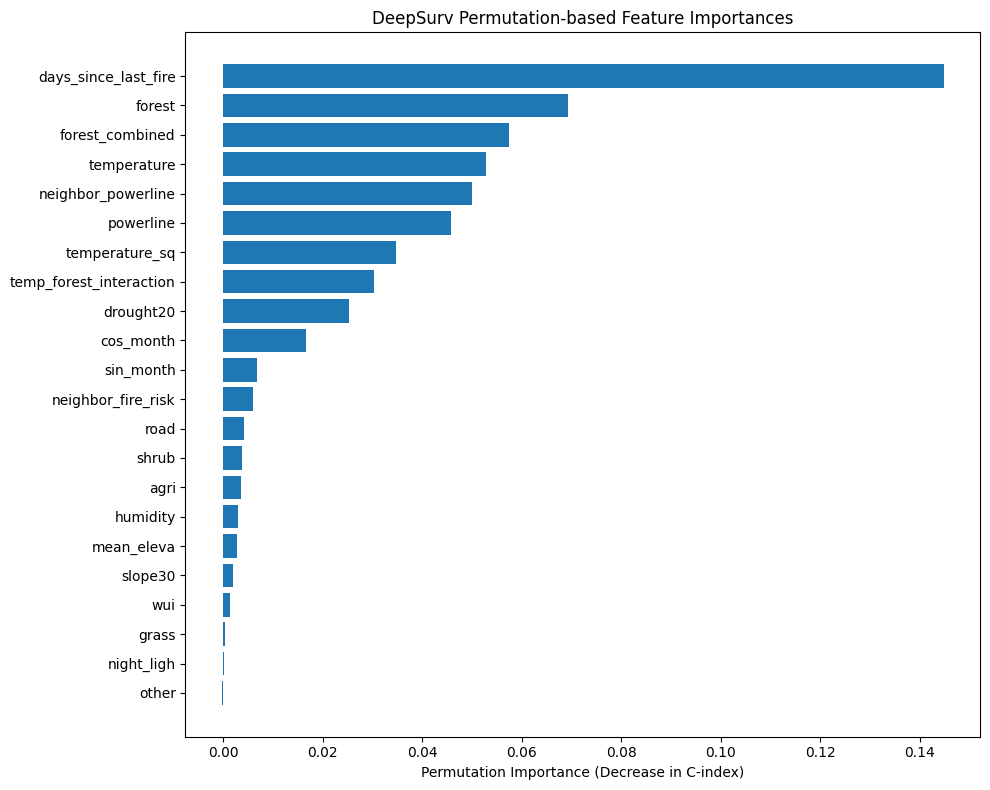

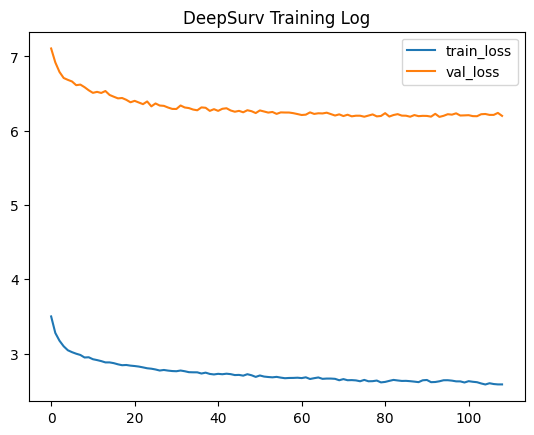

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sksurv.util import Surv
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler


# === Temporal Split ===
TEMPORAL_CUTOFF = 4053
NEIGHBOR_RADIUS = 5000

# # Preprocessing
# event_df["centroid_x"] = event_df["geometry"].apply(lambda g: g.centroid.x)
# event_df["centroid_y"] = event_df["geometry"].apply(lambda g: g.centroid.y)
# event_df["duration"] = event_df["stop_time"] - event_df["start_time"]
# event_df["log_days_since_last_fire"] = np.log1p(event_df["days_since_last_fire"])

# Split data
df_train = df_split[df_split["start_time"] < TEMPORAL_CUTOFF].copy()
df_test = df_split[df_split["start_time"] >= TEMPORAL_CUTOFF].copy()

# Basic preprocessing
for df in [df_train, df_test]:
    df["centroid_x"] = df["geometry"].apply(lambda g: g.centroid.x)
    df["centroid_y"] = df["geometry"].apply(lambda g: g.centroid.y)
    df["duration"] = df["stop_time"] - df["start_time"]
    df["ruggedness"] = df["max_elevat"] - df["mean_eleva"]
    df["elevation_ruggedness_index"] = df["ruggedness"] * df["mean_eleva"]
    df["log_days_since_last_fire"] = np.log1p(df["days_since_last_fire"])

# Compute neighbor features
coords_train = df_train[["centroid_x", "centroid_y"]].values
tree_train = cKDTree(coords_train)

neighbor_features = [
    "neighbor_fire_risk", "neighbor_forest", "neighbor_road",
    "neighbor_powerline"
]

# Initialize neighbor features
for df in [df_train, df_test]:
    for f in neighbor_features:
        df[f] = np.nan


lag_days = 10  # or adjust to your preference
coords_train = df_train[["centroid_x", "centroid_y"]].values
coords_test  = df_test[["centroid_x",  "centroid_y"]].values
tree_train   = cKDTree(coords_train)

# TRAIN SET — uses historical neighbors only (with lag)
for i, pt in enumerate(coords_train):
    my_start = df_train.iloc[i]["start_time"]
    all_nb = tree_train.query_ball_point(pt, NEIGHBOR_RADIUS)
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_train.iloc[past_nb]
    dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_train.loc[df_train.index[i], "neighbor_fire_risk"]  = sub["fire_occurred_x"].sum() / sub["duration"].sum()
    df_train.loc[df_train.index[i], "neighbor_forest"]     = np.average(sub["forest"], weights=w)
    df_train.loc[df_train.index[i], "neighbor_road"]       = np.average(sub["road"], weights=w)
    df_train.loc[df_train.index[i], "neighbor_powerline"]  = np.average(sub["powerline"], weights=w)

# TEST SET — use only TRAIN history
for i, pt in enumerate(coords_test):
    my_start = df_test.iloc[i]["start_time"]
    all_nb = tree_train.query_ball_point(pt, NEIGHBOR_RADIUS)
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_train.iloc[past_nb]
    dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_test.loc[df_test.index[i], "neighbor_fire_risk"]  = sub["fire_occurred_x"].sum() / sub["duration"].sum()
    df_test.loc[df_test.index[i], "neighbor_forest"]     = np.average(sub["forest"], weights=w)
    df_test.loc[df_test.index[i], "neighbor_road"]       = np.average(sub["road"], weights=w)
    df_test.loc[df_test.index[i], "neighbor_powerline"]  = np.average(sub["powerline"], weights=w)

# Fill remaining NaNs
neighbor_features = ["neighbor_forest", "neighbor_road", "neighbor_powerline"]
for df in [df_train, df_test]:
    df[neighbor_features] = df[neighbor_features].fillna(df_train[neighbor_features].median())
    df["neighbor_fire_risk"] = df["neighbor_fire_risk"].fillna(0.0)

for df in [df_train, df_test]:
    df["forest_combined"] = (df["forest"] + df["neighbor_forest"]) / 2
    df["road_combined"] = (df["road"] + df["neighbor_road"]) / 2
    df["temperature_sq"] = df["temperature"] ** 2
    # df["wind_speed_sq"] = df["wind_speed"] ** 2
    df["temp_forest_interaction"] = df["temperature"] * df["forest_combined"]
    df["dsf_x_no_prior"] = df["days_since_last_fire"] * df["no_prior_fire"]

cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "temperature_sq", "temp_forest_interaction",  "cos_month", "sin_month"
    ]
scaler = MinMaxScaler()
# scaler = StandardScaler()
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

features = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "temperature_sq", "temp_forest_interaction",  "cos_month", "sin_month"
    ]

X_train = df_train[features].values.astype("float32")
X_test = df_test[features].values.astype("float32")
durations_train = df_train["duration"].values.astype("float32")
events_train = df_train["fire_occurred_x"].astype(int).values.astype("float32")
durations_test = df_test["duration"].values.astype("float32")
events_test = df_test["fire_occurred_x"].astype(int).values.astype("float32")

in_features = X_train.shape[1]
net = tt.practical.MLPVanilla(in_features, [64, 64, 64, 64, 63], 1, activation=torch.nn.ReLU, batch_norm=True, dropout=0.5)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
model = CoxPH(net, optimizer)

callbacks = [tt.callbacks.EarlyStopping(patience=15)]
model.fit(X_train, (durations_train, events_train), batch_size=64, epochs=500,
          callbacks=callbacks, val_data=(X_test, (durations_test, events_test)), verbose=True)

model.compute_baseline_hazards()
surv = model.predict_surv_df(X_test)
times = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index = ev.concordance_td("antolini")
print(f"DeepSurv Test C-index: {c_index:.4f}")

model.input_cols = features
ensemble_models_deepsurv = [{
    "model": model,
    "scaler": scaler,
    "df_train_raw": df_train,  # or rename to df_train if needed
    "coords_train": coords_train,
    "tree_train": tree_train,
    "features": model.input_cols 
}]


# Manual Permutation Importance for DeepSurv
baseline_score = c_index
importances = []
X_test_copy = X_test.copy()

for col in range(X_test.shape[1]):
    X_permuted = X_test_copy.copy()
    np.random.shuffle(X_permuted[:, col])
    surv_perm = model.predict_surv_df(X_permuted)
    ev_perm = EvalSurv(surv_perm, durations_test, events_test, censor_surv="km")
    perm_score = ev_perm.concordance_td("antolini")
    importances.append(baseline_score - perm_score)

importances = np.array(importances)
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in C-index)")
plt.title("DeepSurv Permutation-based Feature Importances")
plt.tight_layout()
plt.show()

model.input_cols = features
model_log = model.log
model_log.plot()
plt.title("DeepSurv Training Log")
plt.show()


In [12]:
import numpy as np
from sksurv.metrics import concordance_index_censored

# 1) Precompute the risk scores once
cox_scores = cph.predict_partial_hazard(df_test_final).values
rsf_scores = rsf.predict(df_test[rsf_features].reset_index(drop=True))
ds_scores  = model.predict(X_test)          # shape (n,1)
ds_scores  = np.squeeze(ds_scores)          # now shape (n,)

durations = df_test["duration"].values
events    = df_test["fire_occurred_x"].values.astype(bool)
n_obs     = len(durations)

# 2) Bootstrap all three comparisons
n_boot = 1000
diff_rsf_cox = np.empty(n_boot)
diff_ds_cox  = np.empty(n_boot)
diff_rsf_ds  = np.empty(n_boot)

rng = np.random.default_rng(42)
for i in range(n_boot):
    idx = rng.integers(0, n_obs, n_obs)
    e = events[idx]
    t = durations[idx]

    ci_cox = concordance_index_censored(e, t, cox_scores[idx])[0]
    ci_rsf = concordance_index_censored(e, t, rsf_scores[idx])[0]
    ci_ds  = concordance_index_censored(e, t, ds_scores [idx])[0]

    diff_rsf_cox[i] = ci_rsf - ci_cox
    diff_ds_cox [i] = ci_ds  - ci_cox
    diff_rsf_ds [i] = ci_rsf - ci_ds

# 3) Summarize
def summarize(d):
    m = d.mean()
    lo, hi = np.percentile(d, [2.5, 97.5])
    return m, lo, hi

m1,l1,h1 = summarize(diff_rsf_cox)
m2,l2,h2 = summarize(diff_ds_cox)
m3,l3,h3 = summarize(diff_rsf_ds)

print(f"RSF - CoxPH:      ΔC = {m1:.3f}, 95% CI = [{l1:.3f}, {h1:.3f}]")
print(f"DeepSurv - CoxPH: ΔC = {m2:.3f}, 95% CI = [{l2:.3f}, {h2:.3f}]")
print(f"RSF - DeepSurv:   ΔC = {m3:.3f}, 95% CI = [{l3:.3f}, {h3:.3f}]")


RSF - CoxPH:      ΔC = 0.025, 95% CI = [0.019, 0.030]
DeepSurv - CoxPH: ΔC = 0.067, 95% CI = [0.061, 0.073]
RSF - DeepSurv:   ΔC = -0.042, 95% CI = [-0.048, -0.037]


In [13]:
from scipy.stats import shapiro, ttest_1samp, wilcoxon


for name, diffs in [
    ("RSF - CoxPH",    diff_rsf_cox),
    ("DeepSurv - CoxPH", diff_ds_cox),
    ("RSF - DeepSurv", diff_rsf_ds),
]:
    # 1) Normality of the Δ-distribution
    W, p_sh = shapiro(diffs)
    # 2) One-sample t-test: is mean ≠ 0?
    t, p_t = ttest_1samp(diffs, 0)
    # 3) Wilcoxon signed-rank: is median ≠ 0?
    Ww, p_w = wilcoxon(diffs - 0)  

    print(f"{name}:")
    print(f"  Shapiro-Wilk: W = {W:.3f}, p = {p_sh:.3f}")
    print(f"  t-test      : t = {t:.3f}, p = {p_t:.4f}")
    print(f"  Wilcoxon    : W = {Ww},   p = {p_w:.4f}\n")


RSF - CoxPH:
  Shapiro-Wilk: W = 0.999, p = 0.842
  t-test      : t = 259.982, p = 0.0000
  Wilcoxon    : W = 0.0,   p = 0.0000

DeepSurv - CoxPH:
  Shapiro-Wilk: W = 0.999, p = 0.780
  t-test      : t = 654.635, p = 0.0000
  Wilcoxon    : W = 0.0,   p = 0.0000

RSF - DeepSurv:
  Shapiro-Wilk: W = 0.999, p = 0.724
  t-test      : t = -452.237, p = 0.0000
  Wilcoxon    : W = 0.0,   p = 0.0000



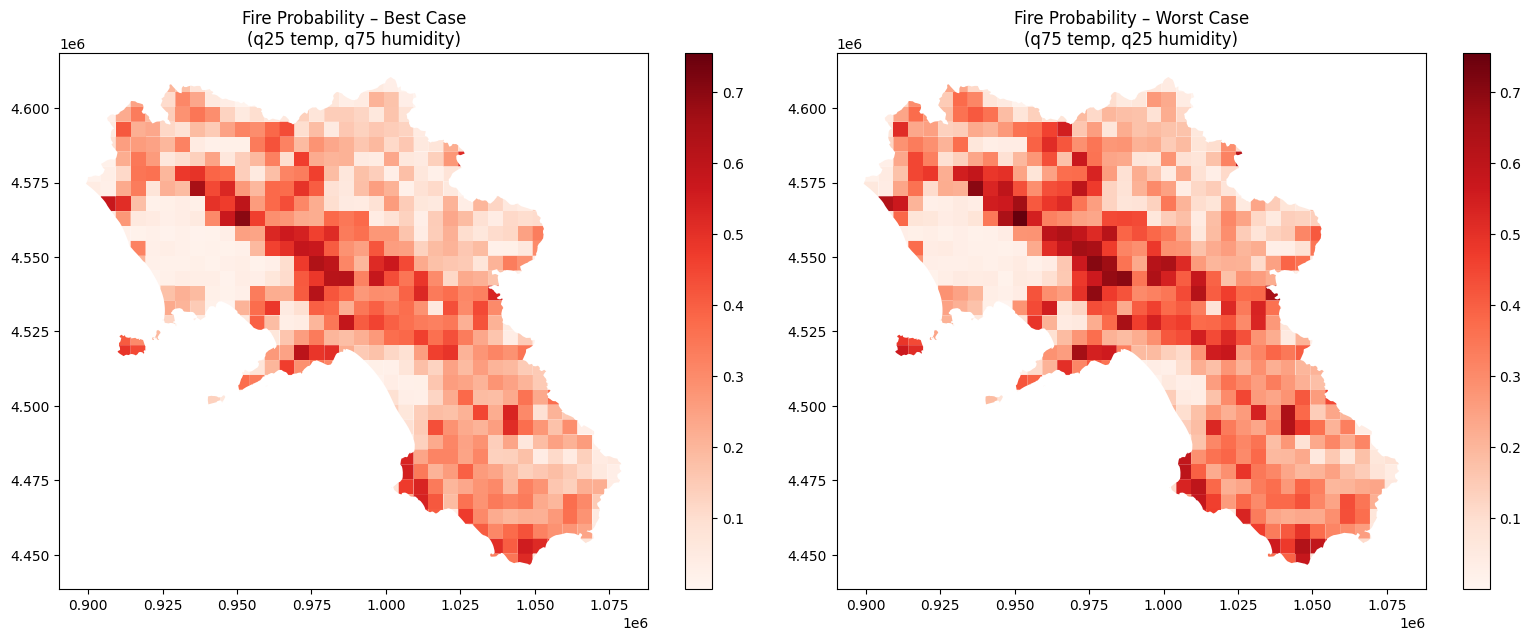

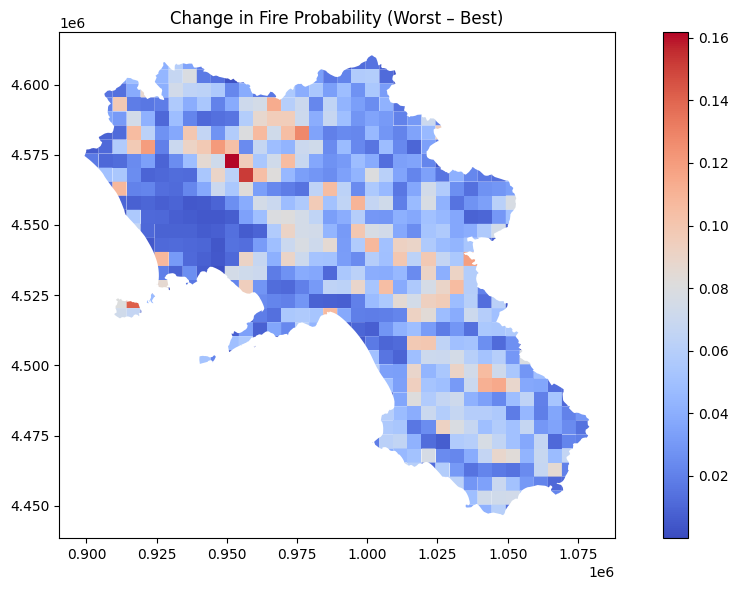

In [49]:
if not isinstance(df_split, gpd.GeoDataFrame):
    df_split = gpd.GeoDataFrame(df_split, geometry="geometry")
df_split["centroid_x"] = df_split.geometry.centroid.x
df_split["centroid_y"] = df_split.geometry.centroid.y


def create_fire_probability_map_deepsurv_intervals(
    ensemble_models,
    event_df,
    df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=60,
    neighbor_radius=10000,
    stat_dict=None,
    stat="median"
):
    import torch

    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry="geometry")

    gdf_cells = event_df.drop_duplicates(subset="id").copy()

    if stat_dict is None:
        stat_dict = {
            "temperature": "median",
            "humidity":  "median",
            "drought20": "median",
            "wind_speed": "median"
        }

    intervals = [(0, 20), (20, 41), (41, forecast_horizon)]

    model = ensemble_models[0]["model"]
    scaler = ensemble_models[0]["scaler"]
    input_cols = model.input_cols
    df_train_raw = ensemble_models[0]["df_train_raw"]
    coords_train = ensemble_models[0]["coords_train"]
    tree_train = ensemble_models[0]["tree_train"]

    scaled_cols = scaler.feature_names_in_  # actual columns used during .fit()

    all_probs = []

    for _, cell in gdf_cells.iterrows():
        grid_id = cell["id"]
        baseline = build_baseline_row(event_df, grid_id)
        surv_product = 1.0

        for (start, end) in intervals:
            doy = ((day_of_year - 1) + start) % 365 + 1
            month = day_to_month(doy)
            cos_m, sin_m = compute_seasonality_cos_sin(doy)

            monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)
            row = baseline.copy()
            row.update(monthly_vars)
            row["cos_month"] = cos_m
            row["sin_month"] = sin_m
            row["days_since_last_fire"] = days_since_fire + start

            row = compute_neighbor_features(row, df_train_raw, coords_train, tree_train, neighbor_radius)

            # Defensive filling
            row["forest_combined"] = (row.get("forest", 0.0) + row.get("neighbor_forest", 0.0)) / 2
            row["temperature"] = row.get("temperature", 0.0)
            row["temperature_sq"] = row["temperature"] ** 2
            row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]

            # Fill missing model input features
            for col in input_cols:
                if col not in row:
                    row[col] = 0.0

            # Prepare input DataFrame
            X_row = pd.DataFrame([row])
            X_scaled_part = scaler.transform(X_row[scaled_cols])
            X_final = pd.DataFrame(X_scaled_part, columns=scaled_cols)

            # Add unscaled or engineered features
            for col in input_cols:
                if col not in X_final.columns:
                    X_final[col] = row.get(col, 0.0)

            X_final = X_final[input_cols]

            # Predict survival function
            surv_fn = model.predict_surv_df(torch.tensor(X_final.values, dtype=torch.float32))
            surv_fn = surv_fn.iloc[:, 0]

            # Survival interpolation over time
            times = surv_fn.index.values
            t_start = min(times[-1], start)
            t_end = min(times[-1], end)

            S_start = float(surv_fn.loc[surv_fn.index >= t_start].iloc[0])
            S_end = float(surv_fn.loc[surv_fn.index >= t_end].iloc[0])

            interval_surv = S_end / S_start
            surv_product *= interval_surv


        ignition_prob = 1.0 - surv_product
        all_probs.append(ignition_prob)

    gdf_cells["predicted_prob"] = all_probs
    return gdf_cells

# -------------------------------------------
# Example usage:

stat_dict_best = {
    "temperature": "q25",   # will look up "temperature_q25" in df_monthly
    "humidity":    "q75",   # "humidity_q75"
    "drought20":  "q75",   # "drought20_q75"
    "wind_speed":  "median"
}
stat_dict_worst = {
    "temperature": "q75",
    "humidity":    "q25",
    "drought20":  "q25",
    "wind_speed":  "median"
}

gdf_map_best = create_fire_probability_map_deepsurv_intervals(
    ensemble_models=ensemble_models_deepsurv,
    event_df=df_split,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=60,
    neighbor_radius=5000,
    stat_dict=stat_dict_best
)

gdf_map_worst = create_fire_probability_map_deepsurv_intervals(
    ensemble_models=ensemble_models_deepsurv,
    event_df=df_split,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=60,
    neighbor_radius=5000,
    stat_dict=stat_dict_worst
)

# Plot side by side on the same color scale
vmin = min(gdf_map_best["predicted_prob"].min(), gdf_map_worst["predicted_prob"].min())
vmax = max(gdf_map_best["predicted_prob"].max(), gdf_map_worst["predicted_prob"].max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
gdf_map_best.plot(column="predicted_prob", cmap="Reds", legend=True,
                  ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title("Fire Probability – Best Case\n(q25 temp, q75 humidity)")

gdf_map_worst.plot(column="predicted_prob", cmap="Reds", legend=True,
                   ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title("Fire Probability – Worst Case\n(q75 temp, q25 humidity)")

plt.tight_layout()
plt.show()

# Difference map
gdf_diff = gdf_map_worst.copy()
gdf_diff["delta"] = gdf_map_worst["predicted_prob"] - gdf_map_best["predicted_prob"]

fig, ax = plt.subplots(figsize=(10, 6))
gdf_diff.plot(column="delta", cmap="coolwarm", legend=True, ax=ax)
ax.set_title("Change in Fire Probability (Worst – Best)")
plt.tight_layout()
plt.show()


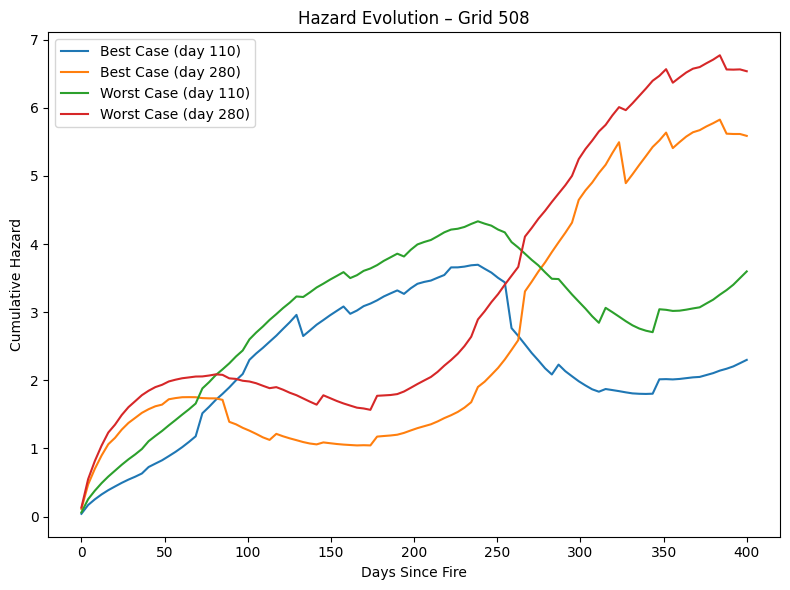

In [ ]:
def compare_fire_timing_overlay_deepsurv(
    ensemble_models,
    df_split,
    df_monthly,
    grid_id,
    initial_day_values=[110, 280],
    forecast_horizon=400,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=None,
    scenario_labels=None
):

    features = [
        "temperature", "drought20", "forest_combined", "grass", "shrub", "forest",
        "neighbor_fire_risk", "neighbor_powerline", "road", "powerline",
        "cos_month", "sin_month", "temperature_sq", "temp_forest_interaction",
        "days_since_last_fire", "mean_eleva", "agri", "humidity", "slope30",
        "night_ligh", "other", "wui"
    ]
    cols_to_scale = [
    "temperature", "drought20", "forest_combined",
    "days_since_last_fire", "neighbor_fire_risk", "neighbor_powerline",
    "grass", "shrub", "agri", "mean_eleva", "humidity", "road", "slope30", "night_ligh",
    "forest", "other", "powerline", "wui", "temperature_sq", "temp_forest_interaction",  "cos_month", "sin_month"
    ]
    derived_features = ["cos_month", "sin_month", "temperature_sq", "temp_forest_interaction"]

    forecast_times = np.linspace(0, forecast_horizon, 100)

    model_obj = ensemble_models[0]
    model = model_obj["model"]
    df_train = model_obj["df_train_raw"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]
    scaler = model_obj["scaler"]

    baseline = build_baseline_row(df_split, grid_id)

    if stat_dicts is None:
        stat_dicts = [
            {"temperature": "q25", "humidity": "q75", "drought_20": "q75"},
            {"temperature": "q75", "humidity": "q25", "drought_20": "q25"},
        ]
    if scenario_labels is None:
        scenario_labels = ["Best Case", "Worst Case"]

    plt.figure(figsize=(8, 6))

    for stat_dict, label in zip(stat_dicts, scenario_labels):
        for init_day in initial_day_values:
            hazard_curve = []
            for t in forecast_times:
                day_t = (init_day + t) % 365
                month = day_to_month(day_t)
                cos_month, sin_month = compute_seasonality_cos_sin(day_t)

                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

                row = baseline.copy()
                row.update(monthly_vars)
                row["days_since_last_fire"] = days_since_fire
                row["cos_month"] = cos_month
                row["sin_month"] = sin_month

                row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)
                row["forest_combined"] = (row["forest"] + row["neighbor_forest"]) / 2
                row["temperature_sq"] = row["temperature"] ** 2
                row["temp_forest_interaction"] = row["temperature"] * row["forest_combined"]

                for f in features:
                    if f not in row:
                        row[f] = 0.0

                X_temp = pd.DataFrame([row])
                X_scaled = pd.DataFrame(
                    scaler.transform(X_temp.loc[:, scaler.feature_names_in_]),
                    columns=scaler.feature_names_in_
                )
                X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
                X_final = X_final[features].values.astype("float32")

                surv_func = model.predict_surv_df(X_final).iloc[:, 0]
                clamped_time = min(t, surv_func.index[-1])
                surv_prob = float(surv_func.loc[surv_func.index >= clamped_time].iloc[0])
                hazard = -np.log(np.clip(surv_prob, 1e-6, 1.0))
                hazard_curve.append(hazard)

            plt.plot(forecast_times, hazard_curve, label=f"{label} (day {init_day})")

    plt.xlabel("Days Since Fire")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution - Grid {grid_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()
compare_fire_timing_overlay_deepsurv(
    ensemble_models=ensemble_models_deepsurv,
    df_split=df_split,
    df_monthly=df_monthly,
    grid_id=508,
    initial_day_values=[110, 280],
    forecast_horizon=400,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=[
        {"temperature": "q25", "humidity": "q75", "drought_20": "q75"},
        {"temperature": "q75", "humidity": "q25", "drought_20": "q25"}
    ],
    scenario_labels=["Best Case", "Worst Case"]
)


DeepSurv IBS: 0.0886 +- 0.0034


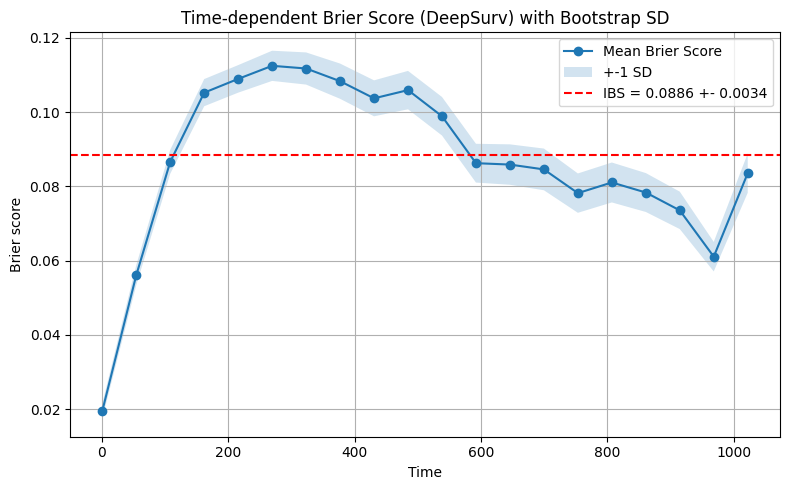

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pycox.evaluation import EvalSurv

# evalSurv once on the full test set
ev_full = EvalSurv(surv, durations_test, events_test, censor_surv='km')

# define evaluation grid
t_min, t_max = durations_test.min(), durations_test.max()
eval_times   = np.linspace(t_min, t_max, 20)

# number of bootstraps 
n_boot = 200
n_times = len(eval_times)
all_bs  = np.zeros((n_boot, n_times))
all_ibs = np.zeros(n_boot)
n_test  = len(durations_test)
idxs    = np.arange(n_test)

# bootstrap loop
for b in range(n_boot):
    boot_idx = np.random.choice(idxs, size=n_test, replace=True)
    # Resample your survival predictions & outcomes
    surv_b       = surv.iloc[:, boot_idx]            # pick columns
    times_b      = durations_test[boot_idx]
    events_b     = events_test   [boot_idx]
    ev_b         = EvalSurv(surv_b, times_b, events_b, censor_surv='km')

    # brier curve + IBS
    bs_curve     = ev_b.brier_score(eval_times)
    ibs_val      = ev_b.integrated_brier_score(eval_times)

    all_bs[b, :] = bs_curve
    all_ibs[b]   = ibs_val

#  bootstrap results
mean_bs = all_bs.mean(axis=0)
std_bs  = all_bs.std(axis=0, ddof=1)
ibs_mean = all_ibs.mean()
ibs_std  = all_ibs.std(ddof=1)

print(f"DeepSurv IBS: {ibs_mean:.4f} +- {ibs_std:.4f}")

# plot with +-1 SD band
plt.figure(figsize=(8,5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="+-1 SD")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"IBS = {ibs_mean:.4f} +- {ibs_std:.4f}")
plt.xlabel("Time")
plt.ylabel("Brier score")
plt.title("Time-dependent Brier Score (DeepSurv) with Bootstrap SD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


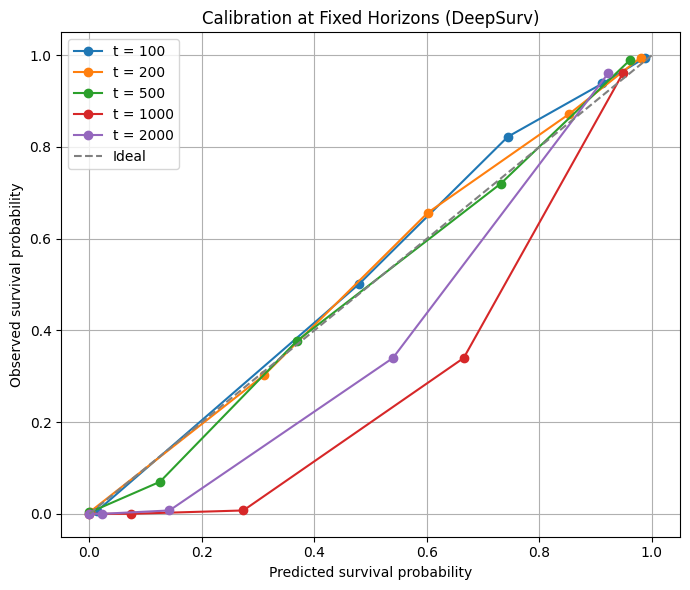

In [15]:
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred_df = surv
cal_data = []
n_bins = 5
time_horizons = [100, 200, 500, 1000, 2000]

for t in time_horizons:
    # interpolate per sample
    n_samples = pred_df.shape[1]
    probs = np.array([
        np.interp(t, pred_df.index, pred_df.iloc[:, j].values)
        for j in range(n_samples)
    ])

    # bin
    bins = pd.qcut(probs, q=n_bins, labels=False, duplicates="drop")

    # loop bins
    for b in np.unique(bins):
        mask = (bins == b)
        if mask.sum() < 5:
            continue

        mean_pred = probs[mask].mean()

        # observed survival via KM (cast events to bool)
        dur = durations_test[mask]
        evt = events_test[mask].astype(bool)

        times_km, surv_km = kaplan_meier_estimator(evt, dur)
        obs = np.interp(t, times_km, surv_km)

        cal_data.append({
            "horizon": t,
            "pred": mean_pred,
            "obs": obs
        })

# turn into DataFrame & plot
cal_df = pd.DataFrame(cal_data)

plt.figure(figsize=(7, 6))
for t in cal_df["horizon"].unique():
    sub = cal_df[cal_df["horizon"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Fixed Horizons (DeepSurv)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


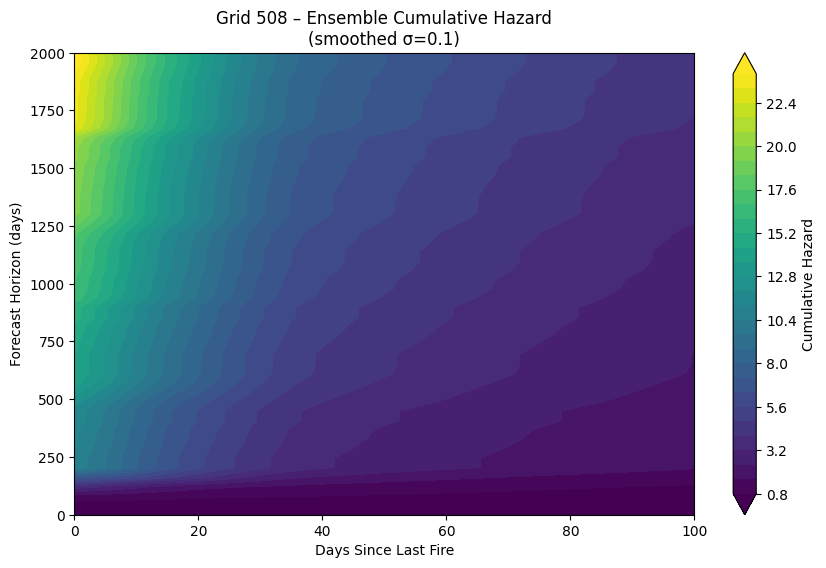

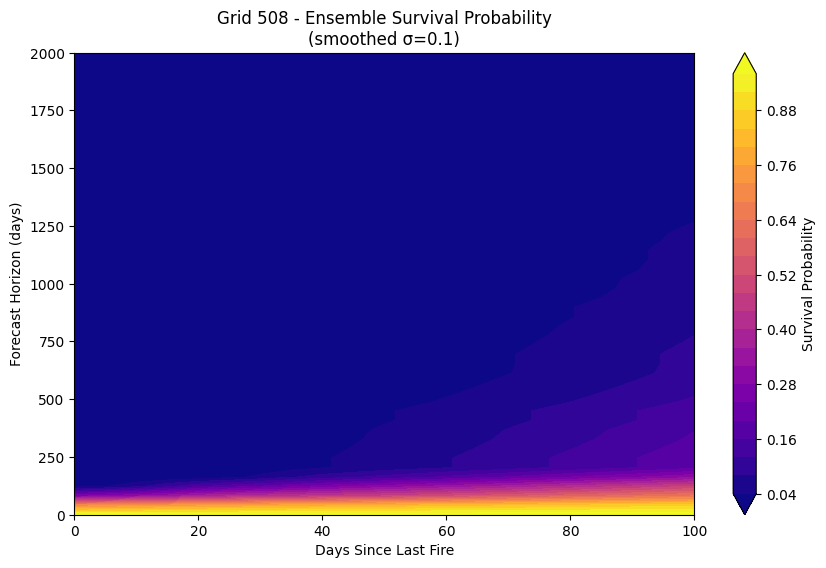

In [45]:
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

def predict_and_plot_with_DeepSurv_ensemble(
    deep_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=5000,
    sigma=0.1,
    delta_t=50
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')
    if 'centroid_x' not in event_df.columns:
        event_df['centroid_x'] = event_df.geometry.centroid.x
        event_df['centroid_y'] = event_df.geometry.centroid.y

    # ranges for axes
    days_since_fire_range = np.arange(0, 101, 5)
    forecast_range       = np.linspace(0, 2000, 50)

    # pre-allocate
    survival_matrix = np.zeros((len(forecast_range), len(days_since_fire_range)))
    hazard_matrix   = np.zeros_like(survival_matrix)

    predictor_vars = deep_models[0]['features']

    for i, forecast_time in enumerate(forecast_range):
        for j, dsf in enumerate(days_since_fire_range):

            cumulative_hazard = 0.0
            time_steps = np.arange(0, forecast_time + delta_t, delta_t)
            prev_H0_val = 0.0

            for t_step in time_steps:

                # recompute weather at this point in time
                month = day_to_month(t_step % 365)
                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

                # build X(t_step)
                row = build_baseline_row(event_df, grid_id)
                row.update(monthly_vars)
                row["days_since_last_fire"] = dsf
                row["cos_month"], row["sin_month"] = compute_seasonality_cos_sin(t_step)

                for var in ["powerline","grass","shrub","agri","slope30","mean_eleva",
                            "no_prior_fire","humidity","wui","temperature","drought20",
                            "forest","road"]:
                    if pd.isna(row.get(var, np.nan)):
                        row[var] = 0.0

                # neighbor features
                row_mod = compute_neighbor_features(
                    row.copy(),
                    deep_models[0]['df_train_raw'],
                    deep_models[0]['coords_train'],
                    deep_models[0]['tree_train'],
                    neighbor_radius
                )
                row_mod["forest_combined"] = (row_mod["forest"] + row_mod["neighbor_forest"]) / 2
                row_mod["road_combined"]   = (row_mod["road"]   + row_mod["neighbor_road"])   / 2
                row_mod["temperature_sq"]  = row_mod["temperature"] ** 2
                row_mod["temp_forest_interaction"] = (
                    row_mod["temperature"] * row_mod["forest_combined"]
                )

                X_temp = pd.DataFrame([row_mod])[predictor_vars]
                X_scaled = deep_models[0]['scaler'].transform(X_temp).astype('float32')
                X_tensor = torch.tensor(X_scaled.astype('float32'), dtype=torch.float32)

                # ensemble predict log hazard → multiplier
                # ensemble predict log partial hazard → multiplier
                multiplier_preds = []
                for mdl in deep_models:
                    log_partial_hazard_array = mdl['model'].predict(X_scaled)
                    log_partial_hazard = log_partial_hazard_array[0]  # first row in batch


                    multiplier_i = np.exp(log_partial_hazard)
                    multiplier_preds.append(multiplier_i)


                avg_multiplier = np.mean(multiplier_preds)

                # interpolate baseline H0(t_step)
                H0_val = np.interp(
                    t_step,
                    mdl['model'].baseline_cumulative_hazards_.index.values,
                    mdl['model'].baseline_cumulative_hazards_.values.flatten(),
                    right=mdl['model'].baseline_cumulative_hazards_.values.flatten()[-1]
                )

                # incremental delta H0
                delta_H0 = H0_val - prev_H0_val
                prev_H0_val = H0_val

                # accumulate hazard
                cumulative_hazard += delta_H0 * avg_multiplier

            # store result
            hazard_matrix[i, j]   = cumulative_hazard
            survival_matrix[i, j] = np.exp(-cumulative_hazard)

    # smooth & plot
    survival_smooth = gaussian_filter(survival_matrix, sigma=sigma)
    hazard_smooth   = gaussian_filter(hazard_matrix,   sigma=sigma)
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(10,6))
    cf = plt.contourf(Xg, Yg, hazard_smooth, levels=30, cmap='viridis', extend='both')
    plt.colorbar(cf, label='Cumulative Hazard')
    plt.xlabel('Days Since Last Fire')
    plt.ylabel('Forecast Horizon (days)')
    plt.title(f'Grid {grid_id} – Ensemble Cumulative Hazard\n(smoothed σ={sigma})')
    plt.show()

    plt.figure(figsize=(10,6))
    cf2 = plt.contourf(Xg, Yg, survival_smooth, levels=30, cmap='plasma', extend='both')
    plt.colorbar(cf2, label='Survival Probability')
    plt.xlabel('Days Since Last Fire')
    plt.ylabel('Forecast Horizon (days)')
    plt.title(f'Grid {grid_id} - Ensemble Survival Probability\n(smoothed σ={sigma})')
    plt.show()


# call it:
predict_and_plot_with_DeepSurv_ensemble(
    deep_models=ensemble_models_deepsurv,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=508,
    statistic='median',
    neighbor_radius=5000,
    sigma=0.1
)
